<a href="https://colab.research.google.com/github/NK-Mikey/Sentiment-Analysis/blob/main/DisneyLand%20Sentiment%20Final%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **UNLOCKING THE MAGIC OR REVEALING THE MESS?**

## 🏰 Disneyland Guest Review Analysis

## 1. Import Libraries

In [1]:
# Data Handling & Utilities
import pandas as pd
import numpy as np
import calendar
import re
import warnings

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
from wordcloud import WordCloud
import ipywidgets as widgets
from IPython.display import display

# NLP & Text Preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation

# Machine Learning
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#others
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import urllib.request
from math import log, sqrt
import ipywidgets as widgets
from IPython.display import display

# Suppress Warnings
warnings.filterwarnings('ignore')

# Download NLTK Resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

## 2. Data Loading and Inspection

In [2]:
# Load the dataset
disney_df = pd.read_csv('DisneylandReviews.csv', encoding = 'latin1')

# Display the first few rows of the dataset
disney_df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


In [3]:
# To check the no of rows and column
disney_df.shape

(42656, 6)

In [4]:
# To understand the dataset
disney_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42656 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42656 non-null  int64 
 1   Rating             42656 non-null  int64 
 2   Year_Month         42656 non-null  object
 3   Reviewer_Location  42656 non-null  object
 4   Review_Text        42656 non-null  object
 5   Branch             42656 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


In [5]:
# To check the missing values
disney_df.isnull().sum().to_frame(name = "Missing Value").transpose()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
Missing Value,0,0,0,0,0,0


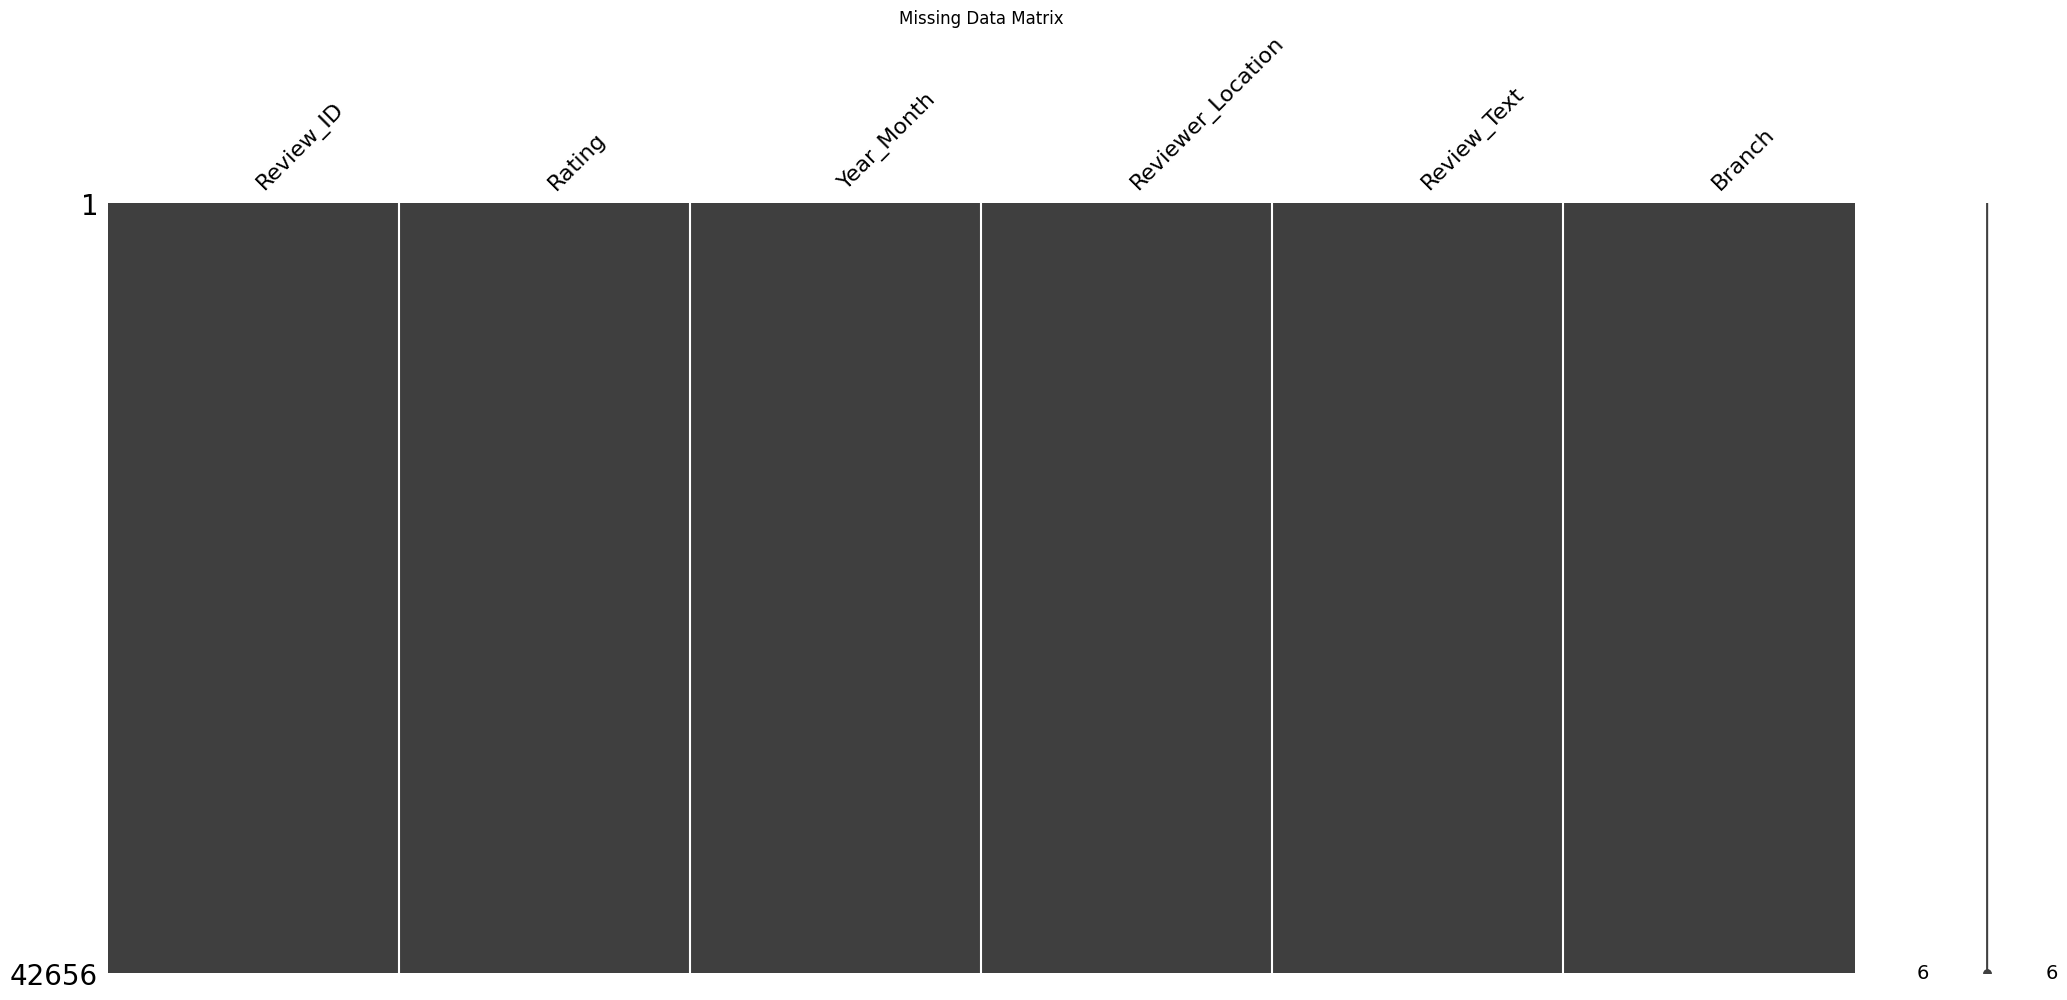

In [6]:
# Visualize the missing value
msno.matrix(disney_df)
plt.title("Missing Data Matrix")
plt.show()

## 3. Data Cleaning

In [7]:
# Removing duplicates from Review column
disney_df.drop_duplicates(subset = ['Review_Text'], inplace = True)

In [8]:
# To check the difference after removing duplicates
print("Shape after removing dupplicates:", disney_df.shape)

Shape after removing dupplicates: (42632, 6)


## 4. Data Summary

In [9]:
# Dataset overview
print(f"Rows       : {disney_df.shape[0]:,}")
print(f"Columns    : {disney_df.shape[1]:,}")
print("\nFeatures   :", disney_df.columns.tolist())

# Missing values
total_missing = disney_df.isnull().sum().sum()
print(f"\nMissing Values : {total_missing:,}")

# Unique values per column
print("\nUnique Values per Column:")
print(disney_df.nunique())

# Value counts for the 'Branch' column
print("\nValue Counts for 'Branch':")
print(disney_df['Branch'].value_counts())

Rows       : 42,632
Columns    : 6

Features   : ['Review_ID', 'Rating', 'Year_Month', 'Reviewer_Location', 'Review_Text', 'Branch']

Missing Values : 0

Unique Values per Column:
Review_ID            42624
Rating                   5
Year_Month             112
Reviewer_Location      162
Review_Text          42632
Branch                   3
dtype: int64

Value Counts for 'Branch':
Branch
Disneyland_California    19399
Disneyland_Paris         13627
Disneyland_HongKong       9606
Name: count, dtype: int64


## 5. Data Preprocessing

In [10]:
# Convert 'Year_Month' assuming format like 'Apr-19' means April 2019
# Standardize column names
disney_df.columns = [col.replace('.', '_') for col in disney_df.columns]

# Convert Year_Month with mixed format handling
def convert_year_month(date_str):
    try:
        # Try format like "Apr-19"
        return pd.to_datetime(date_str, format='%b-%y')
    except ValueError:
        try:
            # Try format like "2019-4"
            return pd.to_datetime(date_str, format='%Y-%m')
        except ValueError:
            return pd.NaT

disney_df['Year_Month'] = disney_df['Year_Month'].apply(convert_year_month)

# Remove rows with invalid dates
initial_count = len(disney_df)
disney_df = disney_df.dropna(subset=['Year_Month'])
cleaned_count = len(disney_df)
print(f"Removed {initial_count - cleaned_count} rows with invalid dates")

Removed 2610 rows with invalid dates


In [11]:
# Extract year, month & day for temporal analysis in EDA
disney_df['Year'] = pd.to_datetime(disney_df['Year_Month']).dt.year
disney_df['Month'] = pd.to_datetime(disney_df['Year_Month']).dt.month

# Remove the 'Year_Month' column
disney_df.drop(columns=['Year_Month'], inplace=True)

# Rearranging the dataset columns
disney_df = disney_df[['Review_ID', 'Rating', 'Year', 'Month', 'Reviewer_Location', 'Review_Text', 'Branch']]

In [12]:
# Verify date column
disney_df.head()

,Review_ID,Rating,Year,Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019,4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019,5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019,4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019,4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019,4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


In [13]:
#Calculating the two lexicon-based sentiment scores
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    if not isinstance(text, str):
        return []
    text = text.lower()
    tokens = re.findall(r'\b[a-z]{3,}\b', text)
    clean_tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words
    ]
    return clean_tokens

disney_df['Tokens'] = disney_df['Review_Text'].apply(preprocess)
disney_df['Clean_Text'] = disney_df['Tokens'].apply(lambda x: ' '.join(x))

## 6. Exploratory Data Analysis

### 6.1 Distribution by Rating

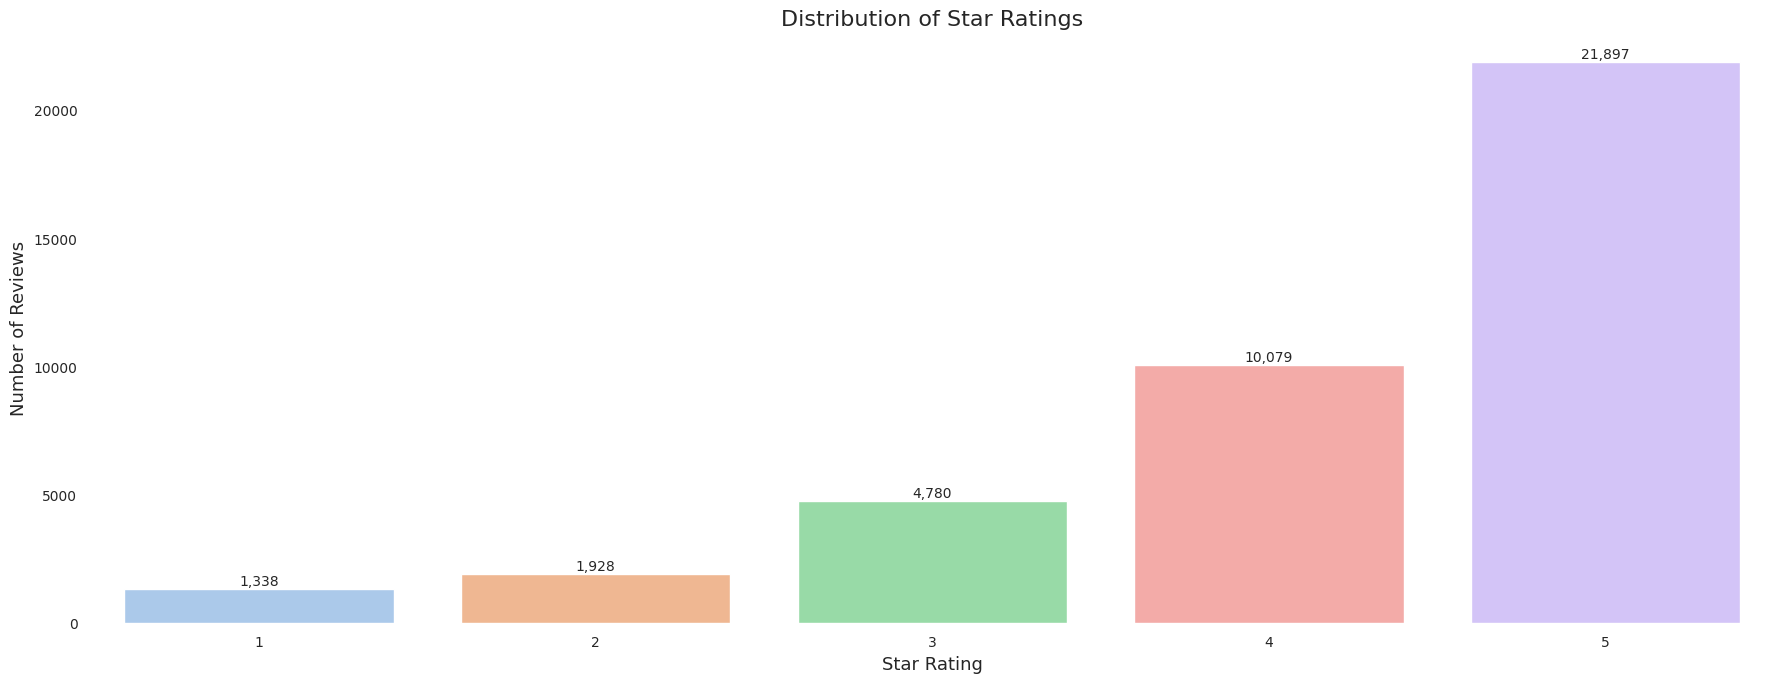

In [14]:
# Custom pastel palette for star rating
sns.set_theme(style='whitegrid')
custom_palette = sns.color_palette("pastel")[:5]

# Set up the figure
plt.figure(figsize=(18, 7))

# Create the countplot
sns.countplot(
    x='Rating',
    data=disney_df,
    hue='Rating',
    palette=custom_palette,
    order=sorted(disney_df['Rating'].unique()),
    legend=False
)

# Get current axis
ax = plt.gca()

# Titles and labels
ax.set_title('Distribution of Star Ratings', fontsize=16)
ax.set_xlabel('Star Rating', fontsize=13)
ax.set_ylabel('Number of Reviews', fontsize=13)
ax.set_facecolor('white')
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

# Remove outline (spines)
for spine in ax.spines.values():
    spine.set_visible(False)

# Remove grid
ax.grid(False)

# Add value labels on top of bars
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height:,}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

The chart shows the distribution of star ratings across all Disneyland guest reviews. The data is heavily skewed toward positive experiences, with the majority of reviews being 5 stars (21,897) and 4 stars (10,079). In contrast, lower ratings are much less common, with only 1,338 reviews rated 1 star and 1,928 rated 2 stars. This suggests that most visitors report high satisfaction levels, indicating generally favorable guest experiences across the parks.

### 6.2 Rating Distribution by Park

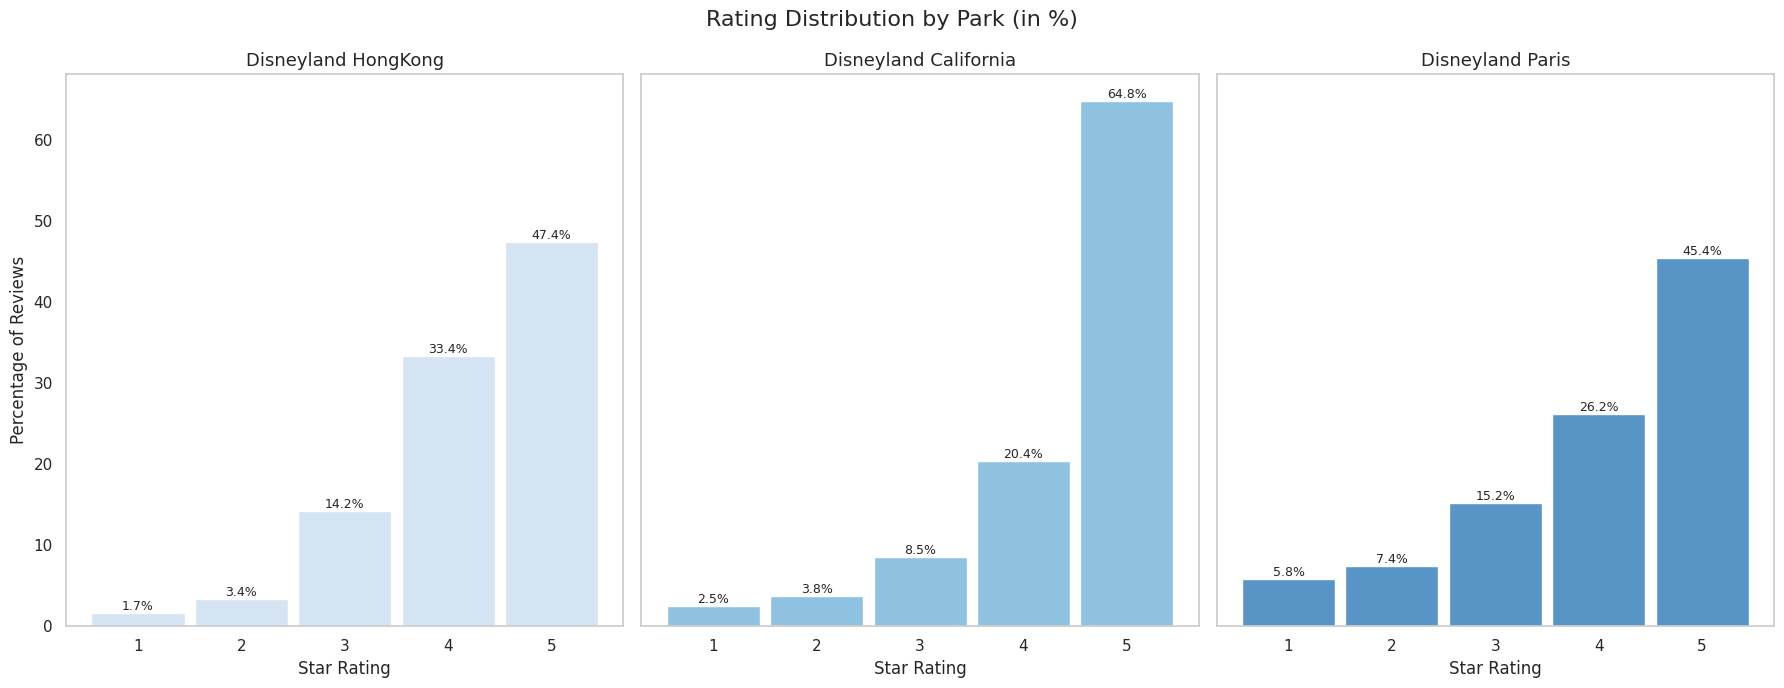

In [15]:
# Set a theme and color palette
sns.set_theme(style='whitegrid')
custom_palette = sns.color_palette('Blues', n_colors=3)

# Prepare unique parks
branch_list = disney_df['Branch'].unique()
n_parks = len(branch_list)

# Set up subplot grid
fig, axes = plt.subplots(1, n_parks, figsize=(18, 7), sharey=True)
axes = axes.flatten()

# Main title
fig.suptitle('Rating Distribution by Park (in %)', fontsize=16)

# Plot each park
for i, branch in enumerate(branch_list):
    ax = axes[i]
    data = disney_df[disney_df['Branch'] == branch]

    # Clean display name
    branch_clean = branch.replace('_', ' ')

    sns.histplot(
        data=data,
        x='Rating',
        stat='percent',
        discrete=True,
        bins=5,
        shrink=0.9,
        color=custom_palette[i],
        ax=ax
    )

    ax.set_title(branch_clean, fontsize=13)
    ax.set_xlabel('Star Rating')
    ax.grid(False)

    if i == 0:
        ax.set_ylabel('Percentage of Reviews')
    else:
        ax.set_ylabel('')

    # Add percentage labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', fontsize=9)

# Adjust spacing
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

The chart compares the percentage distribution of star ratings across the three Disneyland parks, Hong Kong, California, and Paris. Disneyland California stands out with the highest proportion of 5-star reviews at 64.8%, indicating a strong overall guest satisfaction. Hong Kong Disneyland follows with 47.4% of reviews rated 5 stars and a more even distribution across 3- and 4-star ratings, suggesting a slightly more mixed experience. Disneyland Paris has the lowest share of top ratings (45.4%) and the highest proportion of 1- and 2-star reviews among the three parks, reflecting relatively lower satisfaction. These differences highlight variations in guest experience by location and suggest areas where service or operational improvements may be needed.

### 6.3 Reviews by Disneyland Park

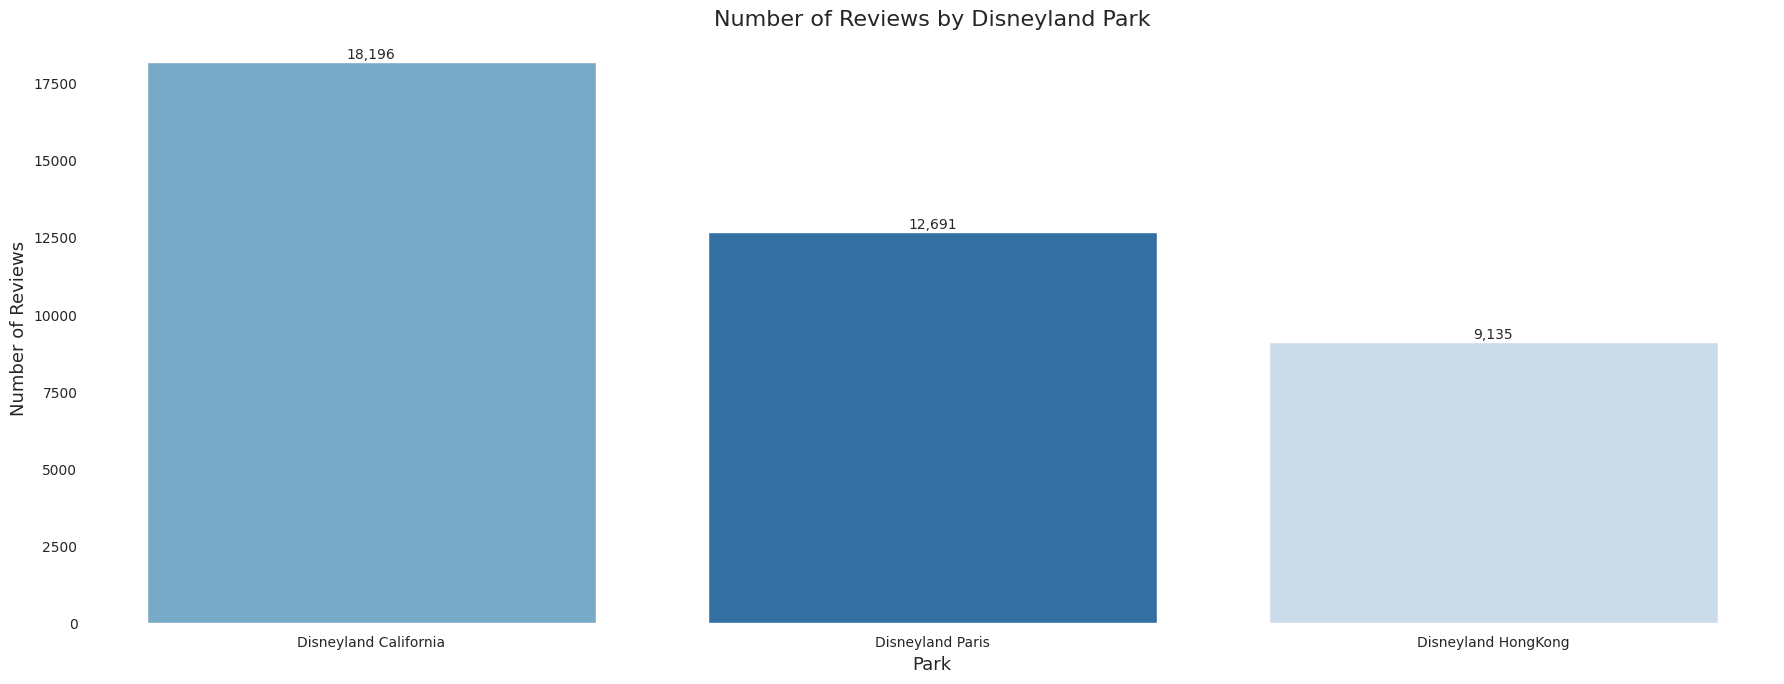

In [16]:
# Set Seaborn style
sns.set_style("whitegrid")
custom_palette = sns.color_palette('Blues', n_colors=3)

# Get ordered branch names and cleaned labels
branch_order = disney_df['Branch'].value_counts().index
branch_labels = [branch.replace('_', ' ') for branch in branch_order]

# Plot
plt.figure(figsize=(18, 7))
ax = sns.countplot(
    x='Branch',
    data=disney_df,
    order=branch_order,
    hue='Branch',
    palette=custom_palette,
    legend=False
)

# x-axis ticks with readable labels
ax.set_xticks(range(len(branch_order)))
ax.set_xticklabels(branch_labels, rotation=0)

# Titles and labels
ax.set_title('Number of Reviews by Disneyland Park', fontsize=16)
ax.set_xlabel('Park', fontsize=13)
ax.set_ylabel('Number of Reviews', fontsize=13)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

# Remove outline borders
for spine in ax.spines.values():
    spine.set_visible(False)

# Add count labels above bars
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height:,}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.grid(False)
plt.show()

The chart displays the total number of guest reviews submitted for each Disneyland Park. Disneyland California received the highest number of reviews (18,196), followed by Disneyland Paris with 12,691, and Disneyland Hong Kong with 9,135. This suggests higher visitor engagement or online feedback activity for the California location, possibly due to its larger audience base or longer operational history.

### 6.4 Reviews Over Time (Year & Month)

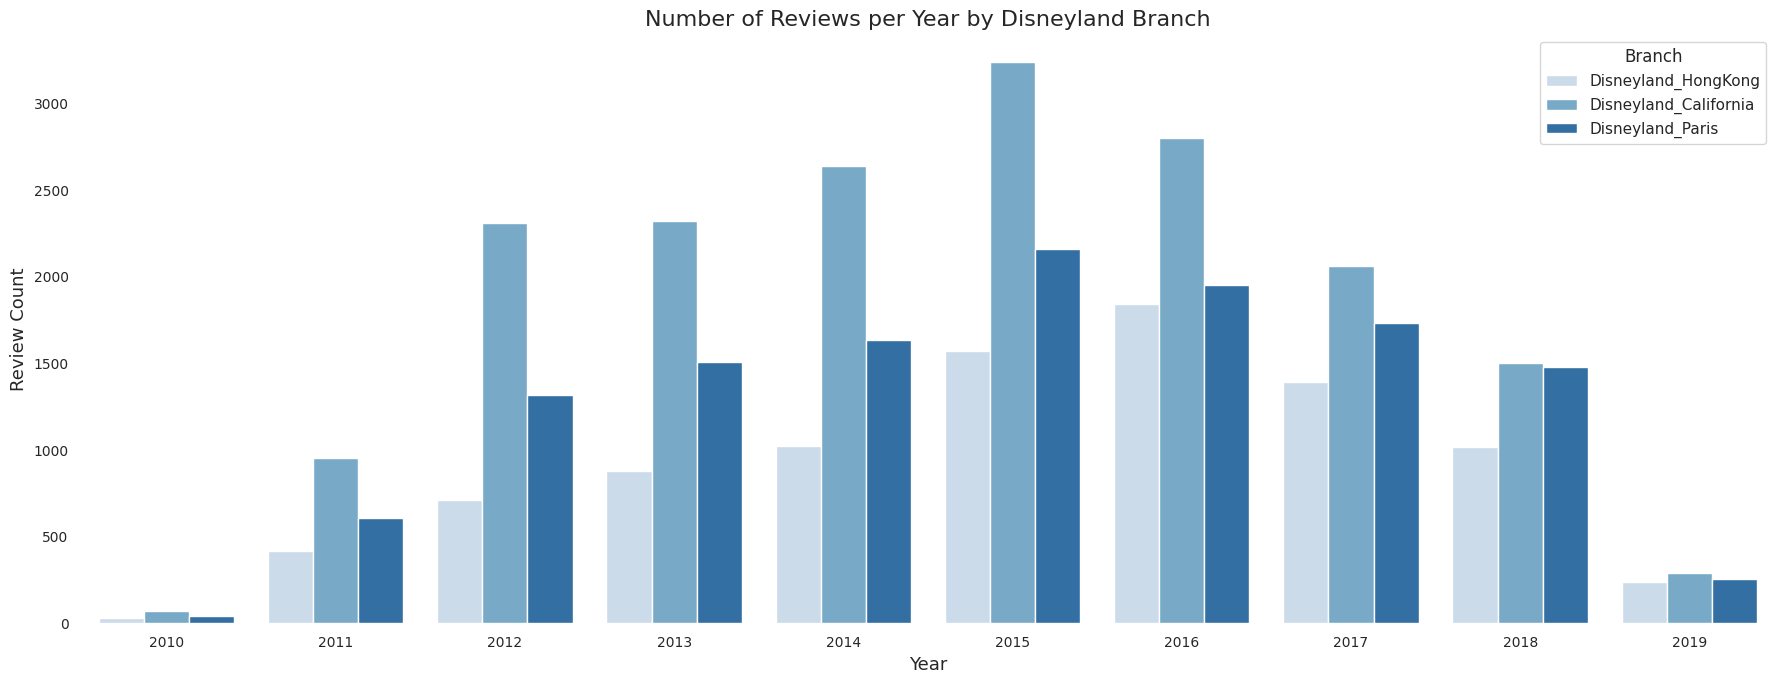

In [17]:
# Set style
sns.set_style("whitegrid")

# Plot
plt.figure(figsize=(18, 7))
ax = sns.countplot(
    x='Year',
    hue='Branch',
    data=disney_df,
    order=sorted(disney_df['Year'].dropna().unique()),
    palette='Blues'
)

# Titles and axis labels
ax.set_title('Number of Reviews per Year by Disneyland Branch', fontsize=16)
ax.set_xlabel('Year', fontsize=13)
ax.set_ylabel('Review Count', fontsize=13)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

# Remove all spines for clean look
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.grid(False)
plt.legend(title='Branch')
plt.show()

The bar chart displays the number of guest reviews per year across Disneyland's three international branches —California, Paris, and Hong Kong —from 2010 to 2019. Disneyland California consistently received the highest volume of reviews each year, peaking in 2015 with over 3,200 reviews, suggesting high engagement and visitor activity. Paris follows with generally lower but steady review volumes, while Hong Kong maintains the smallest share across all years. All parks experienced notable growth in review counts from 2015 to 2016, indicating an increase in guest participation, which may be attributed to rising social media use or park expansions. However, post-2016 shows a general decline in reviews across all locations, potentially due to changing review behavior or data collection limitations. These trends provide context for shifts in guest sentiment and engagement over time and across locations.

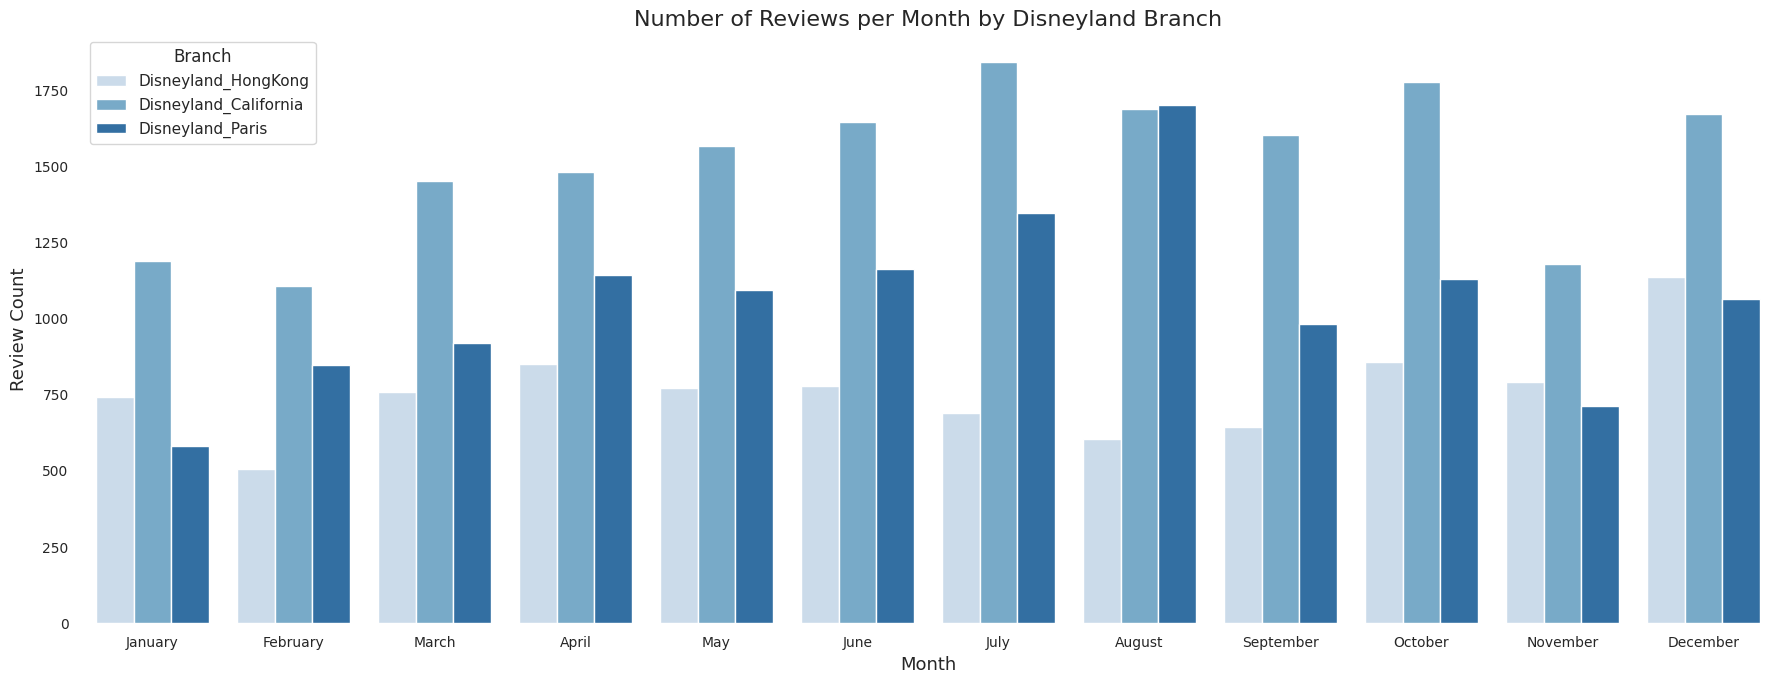

In [18]:
# Map numeric month to month name
disney_df['Month_Name'] = disney_df['Month'].apply(lambda x: calendar.month_name[int(x)] if pd.notnull(x) else x)

# Define ordered categorical for plotting
month_order = list(calendar.month_name)[1:]
disney_df['Month_Name'] = pd.Categorical(disney_df['Month_Name'], categories=month_order, ordered=True)

# Plot
plt.figure(figsize=(18, 7))
ax = sns.countplot(
    x='Month_Name',
    hue='Branch',
    data=disney_df,
    order=month_order,
    palette='Blues'
)

# Titles and labels
ax.set_title('Number of Reviews per Month by Disneyland Branch', fontsize=16)
ax.set_xlabel('Month', fontsize=13)
ax.set_ylabel('Review Count', fontsize=13)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)


# Remove borders
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.grid(False)
plt.legend(title='Branch')
plt.show()

This chart shows the monthly distribution of review counts for Disneyland California, Paris, and Hong Kong, revealing clear seasonal trends across all three branches. Disneyland California consistently receives the highest number of reviews year-round, peaking in July and October, likely due to summer vacations and fall events. Paris also experiences increased activity in spring and summer, with a sharp spike in August, reflecting European holiday patterns. In contrast, Hong Kong’s review volume is lower and more variable, with a notable rise in December, possibly tied to holiday tourism. Overall, the data highlights seasonal peaks in visitor engagement, especially during vacation periods, and underscores California’s dominant presence in English-language reviews.

### 6.5 Top 15 Reviewer Locations

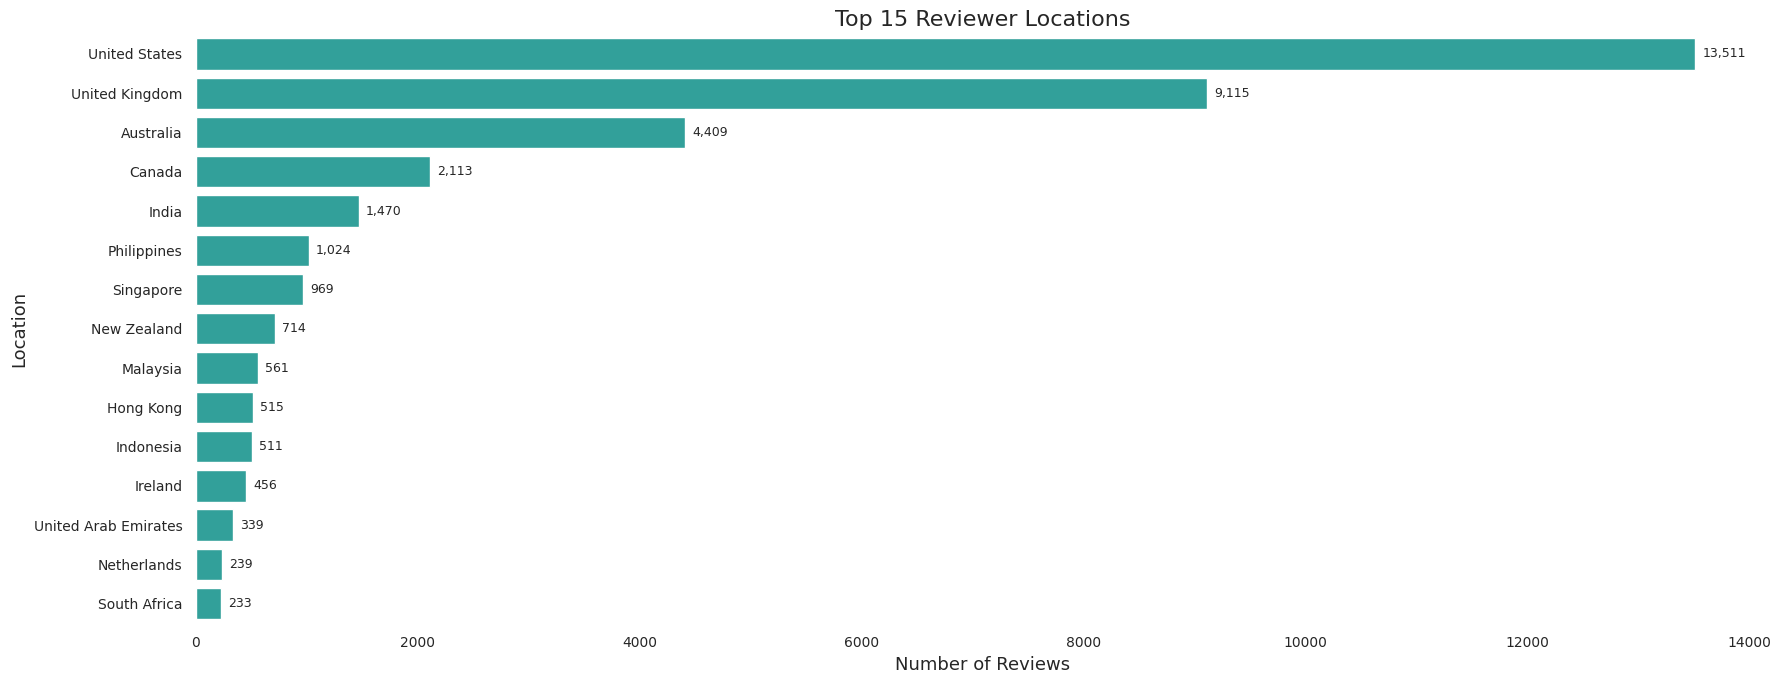

In [19]:
# Extract top 15 reviewer locations by count
top_locations = disney_df['Reviewer_Location'].value_counts().head(15)

plt.figure(figsize=(18, 7))
ax = sns.barplot(
    x=top_locations.values,
    y=top_locations.index,
    color='#20B2AA'
)

# Add titles and labels with larger font
ax.set_title('Top 15 Reviewer Locations', fontsize=16)
ax.set_xlabel('Number of Reviews', fontsize=13)
ax.set_ylabel('Location', fontsize=13)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

# Remove borders
for spine in ax.spines.values():
    spine.set_visible(False)

# Add count labels on bars
for bar in ax.patches:
    width = int(bar.get_width())
    ax.annotate(f'{width:,}',
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(5, 0),
                textcoords='offset points',
                ha='left', va='center',
                fontsize=9)

plt.tight_layout()
plt.grid(False)
plt.show()

The horizontal bar chart displays the top 15 reviewer locations based on the number of Disneyland reviews submitted in English. The United States leads by a significant margin with 13,511 reviews, followed by the United Kingdom (9,115) and Australia (4,409), indicating high engagement from native English-speaking countries. Canada and India also contribute sizable volumes. Notably, while parks like Disneyland Hong Kong are geographically closer to countries like Malaysia and Indonesia, their review counts are relatively lower, likely influenced by the fact that only English-language reviews were included in the analysis. This filtering skews the dataset toward regions where English is commonly spoken or used online, and it's important to consider this when generalizing insights across Disneyland's global audience.

### 6.6 Review Length

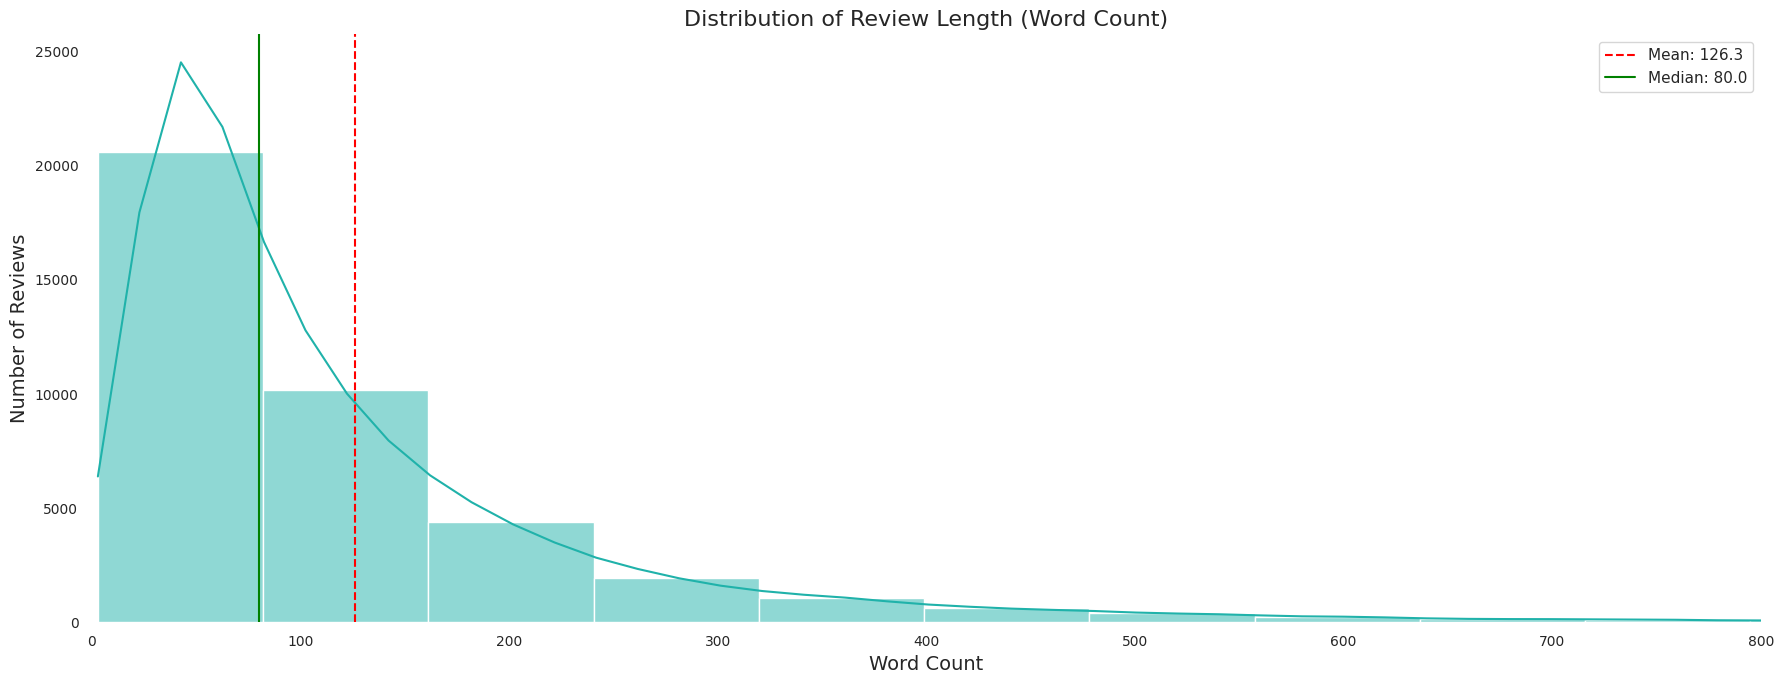

In [20]:
# Calculate review length in words
disney_df['review_length'] = disney_df['Review_Text'].str.split().apply(len)

# Basic stats
mean_len = disney_df['review_length'].mean()
median_len = disney_df['review_length'].median()

# Set plot size
plt.figure(figsize=(18, 7))

# Plot
sns.histplot(disney_df['review_length'], bins=50, kde=True, color='#20B2AA')

# Titles and styles
plt.title('Distribution of Review Length (Word Count)', fontsize=16)
plt.xlabel('Word Count', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)

# Add vertical lines for mean and median
plt.axvline(mean_len, color='red', linestyle='--', label=f'Mean: {mean_len:.1f}')
plt.axvline(median_len, color='green', linestyle='-', label=f'Median: {median_len:.1f}')
plt.legend()

# Remove chart borders/spines
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Optional: remove grid lines
plt.grid(False)

# Limit x-axis
plt.xlim(0, 800)

plt.tight_layout()
plt.show()

The histogram shows the distribution of review lengths (in word count) for Disneyland guest reviews. The distribution is right-skewed, indicating that most reviews are relatively short. The median review length is 80 words (green line), while the mean is higher at approximately 126 words (red dashed line), reflecting the influence of longer outlier reviews. Most reviews fall under 150 words, suggesting that most guests leave brief feedback, possibly focused on key highlights or complaints. The presence of a long tail indicates that a smaller group of reviewers provides more detailed narratives, which are likely valuable for deeper sentiment and thematic analysis.

### 6.7 Rating per Year

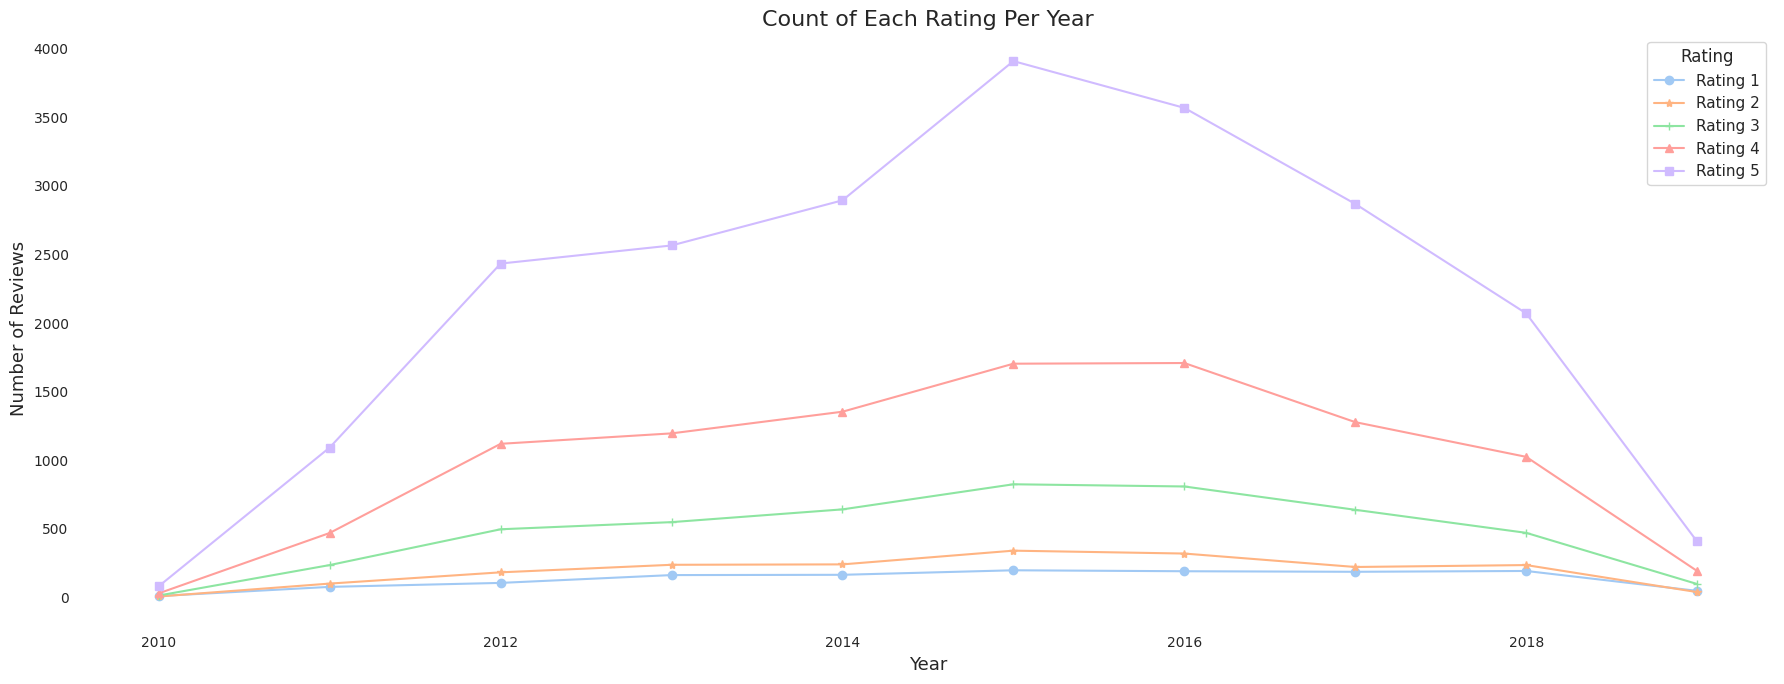

In [21]:
# Count how many times each rating appears per year
rating_counts = (
    disney_df.groupby(['Year', 'Rating'])
    .size()
    .reset_index(name='Count')
)

# Pivot for plotting
rating_pivot = rating_counts.pivot(index='Year', columns='Rating', values='Count').fillna(0)

# Custom pastel palette (exactly 5 colors for 5 ratings)
custom_palette = sns.color_palette("pastel")[:5]

# Plot
plt.figure(figsize=(18, 7))
sns.set_style("white")

markers = ['o', '*', '+', '^', 's']

for i, rating in enumerate(sorted(rating_pivot.columns)):
    plt.plot(
        rating_pivot.index,
        rating_pivot[rating],
        marker=markers[i % len(markers)],
        color=custom_palette[i % len(custom_palette)],
        label=f'Rating {int(rating)}'
    )

# Titles and labels
plt.title('Count of Each Rating Per Year', fontsize=16)
plt.xlabel('Year', fontsize=13)
plt.ylabel('Number of Reviews', fontsize=13)
plt.legend(title='Rating')
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.xticks(rotation=0)

# Remove all borders/spines
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# No grid
plt.grid(False)

plt.tight_layout()
plt.show()

The line chart shows the yearly count of each star rating (from 1 to 5) in Disneyland guest reviews. Across all years, 5-star reviews consistently dominate, peaking in 2015 with nearly 4,000 entries, which aligns with the broader trend of overall review volume. Ratings of 4 stars follow a similar upward trend through 2016 before gradually declining. Lower ratings (1, 2, and 3 stars) remain much less frequent and relatively stable, with minor fluctuations over the years. This distribution reinforces the earlier observation that most reviewers report highly positive experiences. However, the drop in all rating levels after 2016 suggests a decline in review activity or changes in guest behavior, review platforms, or data availability. These patterns highlight that while Disneyland generally maintains strong satisfaction levels, any analysis of trends post-2016 should account for the overall reduction in review submissions.

### 6.8 Review Count & Average Rating by Country

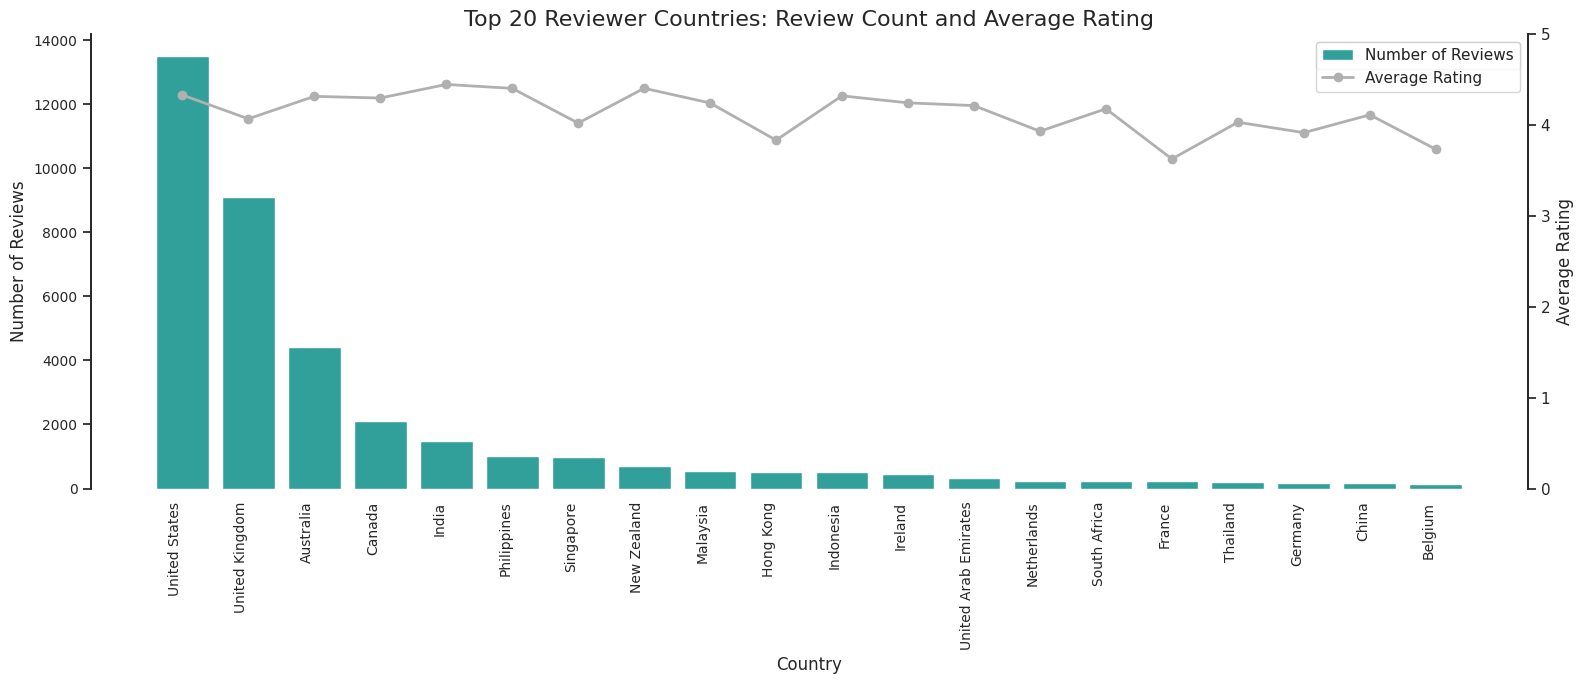

In [22]:
# Group by Reviewer_Location
location_stats = (
    disney_df.groupby('Reviewer_Location')
    .agg(Review_Count=('Rating', 'count'), Avg_Rating=('Rating', 'mean'))
    .sort_values('Review_Count', ascending=False)
    .head(20)
    .reset_index()
)

# Sort by Review_Count for better visual order
location_stats = location_stats.sort_values('Review_Count', ascending=False)

# Plot
plt.figure(figsize=(16, 7))
sns.set_style("white")

# Bar chart for number of reviews
ax = sns.barplot(
    data=location_stats,
    x='Reviewer_Location',
    y='Review_Count',
    color='#20B2AA',
    label='Number of Reviews'
)

plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)

# Create second y-axis for average rating
ax2 = ax.twinx()

# Line plot for average rating
ax2.plot(
    location_stats['Reviewer_Location'],
    location_stats['Avg_Rating'],
    color='#B0B0B0',
    marker='o',
    label='Average Rating',
    linewidth=2
)

# Customize axes
ax.set_xlabel('Country', fontsize=12)
ax.set_ylabel('Number of Reviews', fontsize=12)
ax2.set_ylabel('Average Rating', fontsize=12)
ax.set_title('Top 20 Reviewer Countries: Review Count and Average Rating', fontsize=16)

# Format ticks
ax.set_xticklabels(location_stats['Reviewer_Location'], rotation=90, ha='right')
ax2.set_ylim(0, 5)

# Add legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Remove top and right spines
sns.despine(top=True, right=False, left=False, bottom=True)

# No grid
plt.grid(False)

plt.tight_layout()
plt.show()

This chart displays the top 20 countries by number of English-language Disneyland reviews, along with their corresponding average star ratings. The United States leads with the highest review count, followed by the United Kingdom and Australia, reflecting strong engagement from English-speaking regions. Average ratings across most countries range between 4.0 and 4.5, suggesting overall positive guest experiences regardless of origin. However, countries with fewer reviews, such as France, South Africa, and Belgium, show slightly lower averages, which may indicate more mixed experiences or a tendency to leave reviews only when dissatisfied. It’s important to note that the analysis includes only English-language reviews, which biases the data toward English-speaking countries and may not fully represent the sentiments of the broader international guest base.

## 7. Sentiment Analysis

### 7.1 Text Preprocessing

In [23]:
# Preview
disney_df[['Review_Text', 'Tokens']].head()

,Review_Text,Tokens
0,If you've ever been to Disneyland anywhere you...,"[ever, disneyland, anywhere, find, disneyland,..."
1,Its been a while since d last time we visit HK...,"[since, last, time, visit, disneyland, yet, ti..."
2,Thanks God it wasn t too hot or too humid wh...,"[thanks, god, hot, humid, visiting, park, othe..."
3,HK Disneyland is a great compact park. Unfortu...,"[disneyland, great, compact, park, unfortunate..."
4,"the location is not in the city, took around 1...","[location, city, took, around, hour, kowlon, k..."


### 7.2 Sentiment Analysis (Lexicon-Based)

In [24]:
# Initialize only once
sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return 0.0  # Neutral for empty or invalid input
    score = sia.polarity_scores(text).get('compound', 0.0)
    return round(score, 4)  # Rounded for better readability

# Apply sentiment analysis
disney_df['Sentiment_Score'] = disney_df['Review_Text'].apply(get_sentiment)

# Preview
disney_df[['Review_Text', 'Sentiment_Score']].head()

,Review_Text,Sentiment_Score
0,If you've ever been to Disneyland anywhere you...,0.7069
1,Its been a while since d last time we visit HK...,0.9901
2,Thanks God it wasn t too hot or too humid wh...,0.9920
3,HK Disneyland is a great compact park. Unfortu...,0.8489
4,"the location is not in the city, took around 1...",0.2846


### 7.3 Compare Rating vs Sentiment Score

In [25]:
#Lexicon-Based Sentiment
import urllib.request

def load_lexicon(url):
    lexicon = {}
    response = urllib.request.urlopen(url)
    for line in response:
        word, score = line.decode('utf-8').strip().split('\t')
        lexicon[word] = float(score)
    return lexicon

#URL
lexicon_url = "https://raw.githubusercontent.com/wd13ca/BAN200-Summer-2025/main/lexicon.txt"
lexicon = load_lexicon(lexicon_url)

def vectorize_tf(tokens):
    tf = {}
    for t in tokens:
        tf[t] = tf.get(t, 0) + 1
    return tf

# Calculate TF-IDF weights
N = len(disney_df)
doc_freq = {}
for tokens in disney_df['Tokens']:
    unique_tokens = set(tokens)
    for token in unique_tokens:
        doc_freq[token] = doc_freq.get(token, 0) + 1

idf_dict = {token: log(N / (df_count + 1)) for token, df_count in doc_freq.items()}

def vectorize_tf_idf(tokens):
    tf = vectorize_tf(tokens)
    tf_idf = {}
    for token, freq in tf.items():
        if token in idf_dict:
            tf_idf[token] = freq * idf_dict[token]
    return tf_idf

disney_df['tf_idf'] = disney_df['Tokens'].apply(vectorize_tf_idf)

# Sentiment scoring functions
def sparse_dot_product(vec1, vec2):
    return sum(vec1.get(t, 0) * vec2.get(t, 0) for t in set(vec1) | set(vec2))

disney_df['Lexicon_Score'] = disney_df['tf_idf'].apply(
    lambda x: sparse_dot_product(x, lexicon)
)

# Correlation analysis
corr_tfidf = disney_df['Rating'].corr(disney_df['Lexicon_Score'])
print(f"Correlation between Rating and Lexicon TF-IDF: {corr_tfidf:.3f}")

Correlation between Rating and Lexicon TF-IDF: 0.273


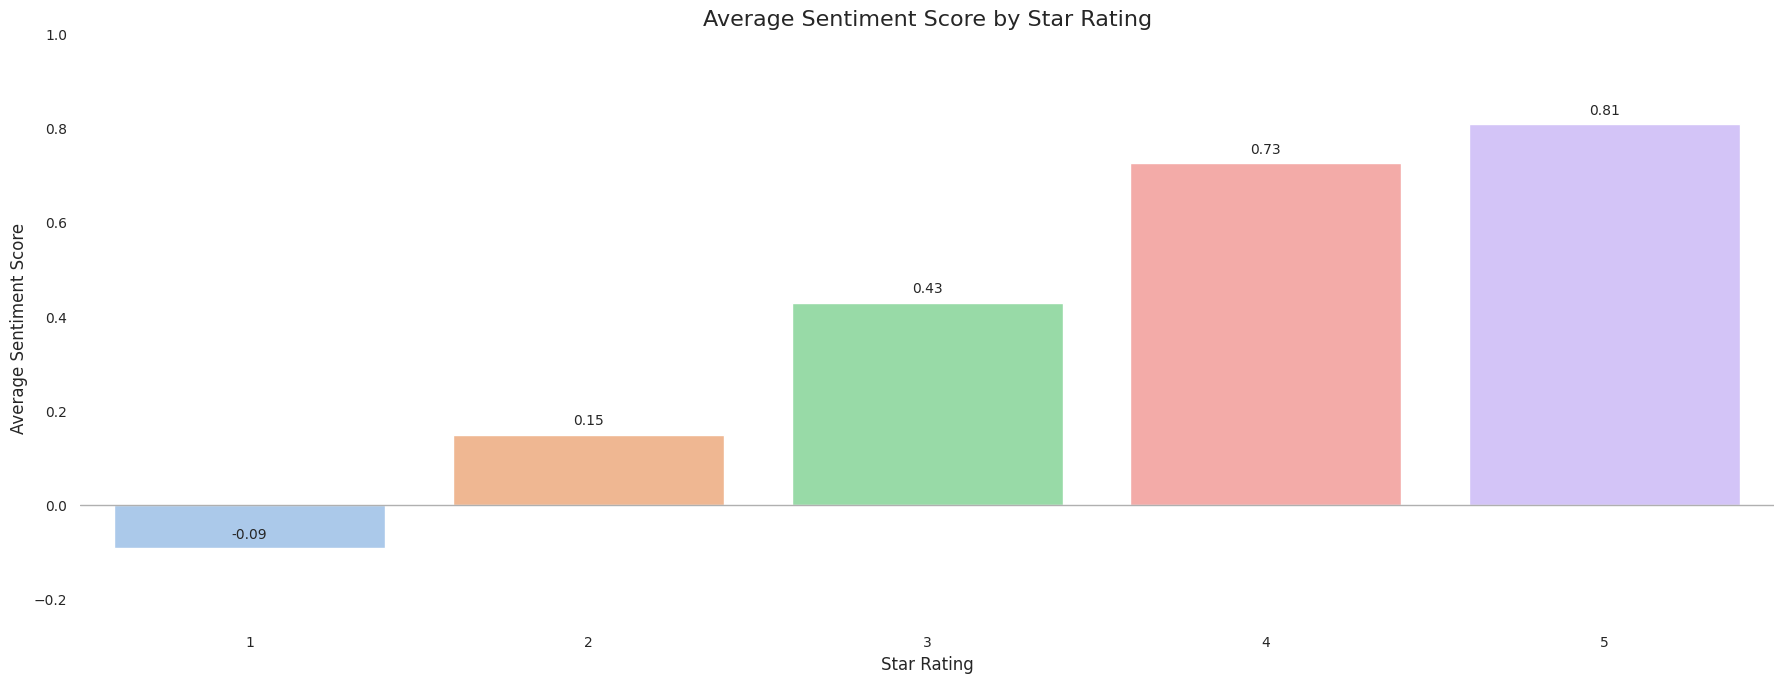

In [26]:
# Group by Rating and calculate average sentiment score
avg_sentiment_by_rating = disney_df.groupby('Rating')['Sentiment_Score'].mean().reset_index()

# Plotting
plt.figure(figsize=(18, 7))
sns.barplot(data=avg_sentiment_by_rating, x='Rating', y='Sentiment_Score', palette='pastel')

# Styling
plt.title('Average Sentiment Score by Star Rating', fontsize=16)
plt.xlabel('Star Rating', fontsize=12)
plt.ylabel('Average Sentiment Score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(-0.25, 1)  # sentiment score range

# Add score labels on bars
for index, row in avg_sentiment_by_rating.iterrows():
    plt.text(row['Rating'] - 1, row['Sentiment_Score'] + 0.02, f"{row['Sentiment_Score']:.2f}",
             ha='center', fontsize=10)

# Add a horizontal line at y=0
plt.axhline(y=0, color='#B0B0B0', linewidth=1)

# Remove grid
plt.grid(False)

# Remove all borders/spines
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Final layout
plt.tight_layout()
plt.show()


### **Average Sentiment Score by Star Rating**

This chart demonstrates a clear positive relationship between review sentiment and star ratings, confirming strong alignment between what guests write and the scores they assign. As expected, higher ratings correspond to increasingly positive sentiment, with 1-star reviews showing negative average sentiment and 5-star reviews showing strongly positive sentiment. However, an important insight emerges when comparing the sentiment scores of 4-star and 5-star reviews. Despite 5-star reviews being nearly twice as frequent as 4-star ones, the average sentiment scores are surprisingly close (0.81 vs. 0.73). This suggests that some 5-star reviewers may have encountered minor inconveniences but still chose to rate their visit as perfect, possibly due to overall satisfaction or brand loyalty. Conversely, 4-star reviewers may have had very positive experiences but withheld a perfect score due to small shortcomings or more discerning standards. This nuance highlights that while sentiment and star ratings generally align, guests’ rating behaviors may reflect a range of expectations and personal thresholds for perfection.


### 7.4 TF-IDF + N-Gram Analysis

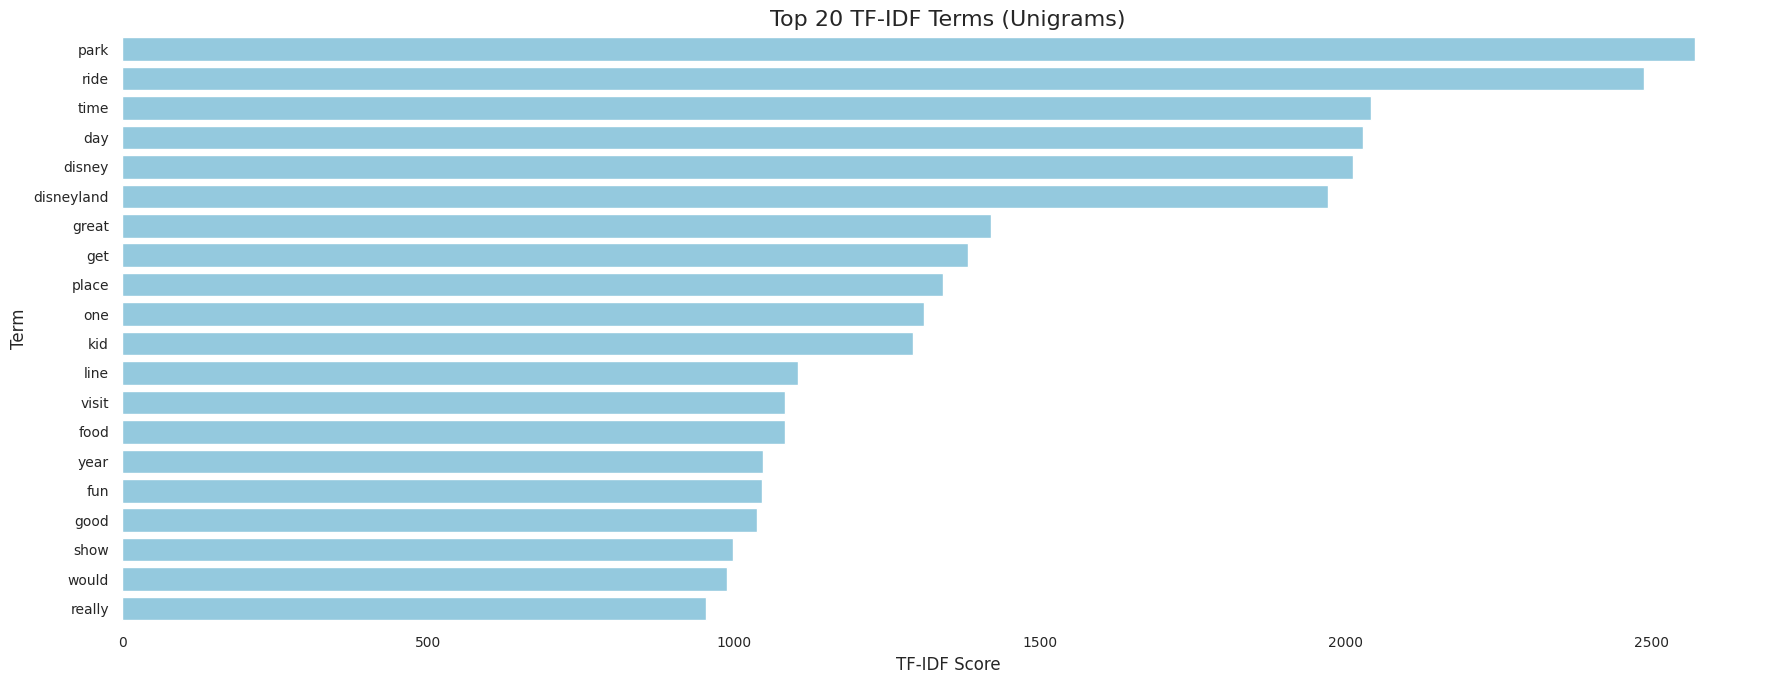

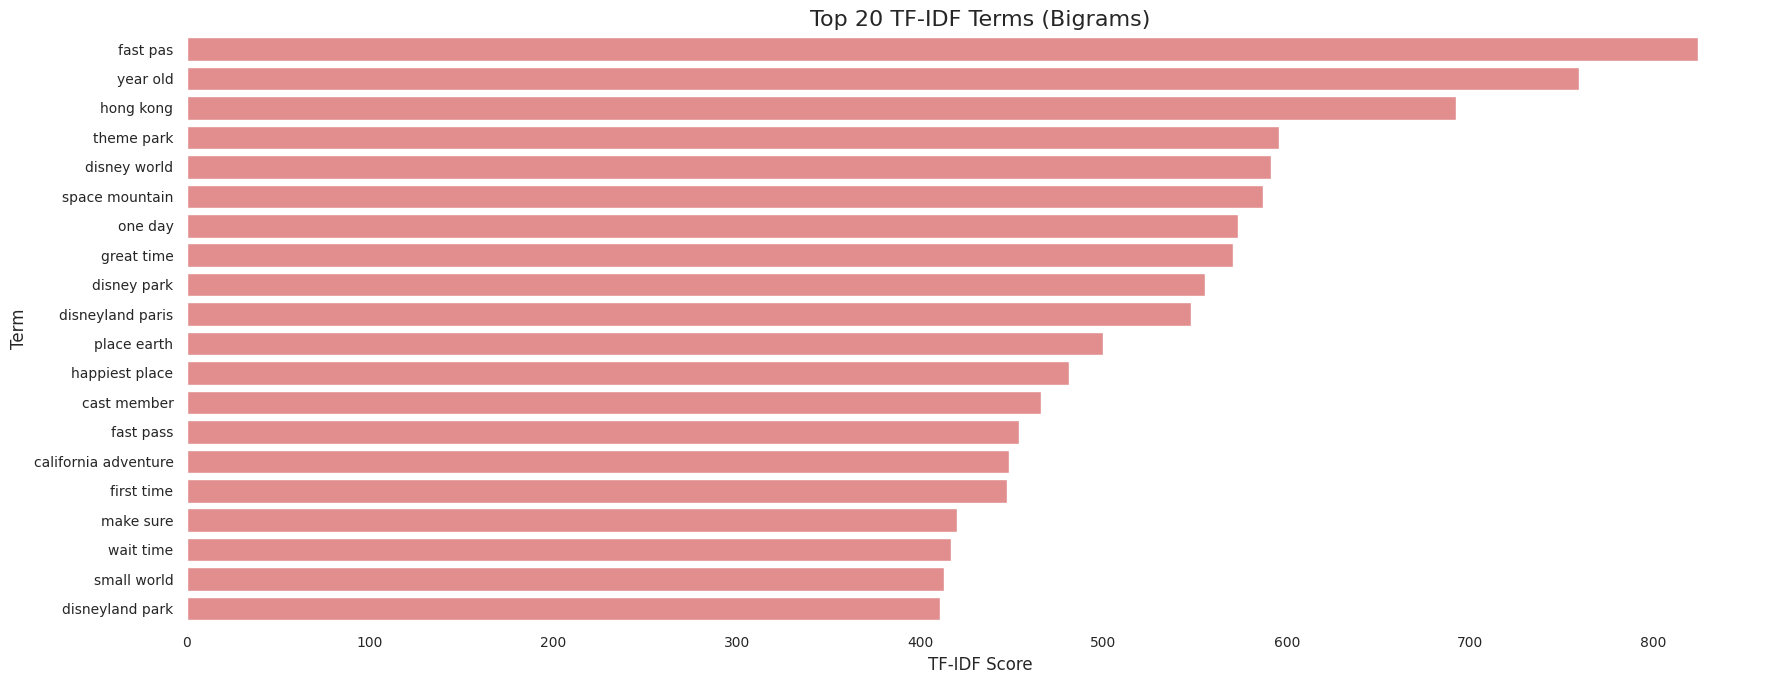

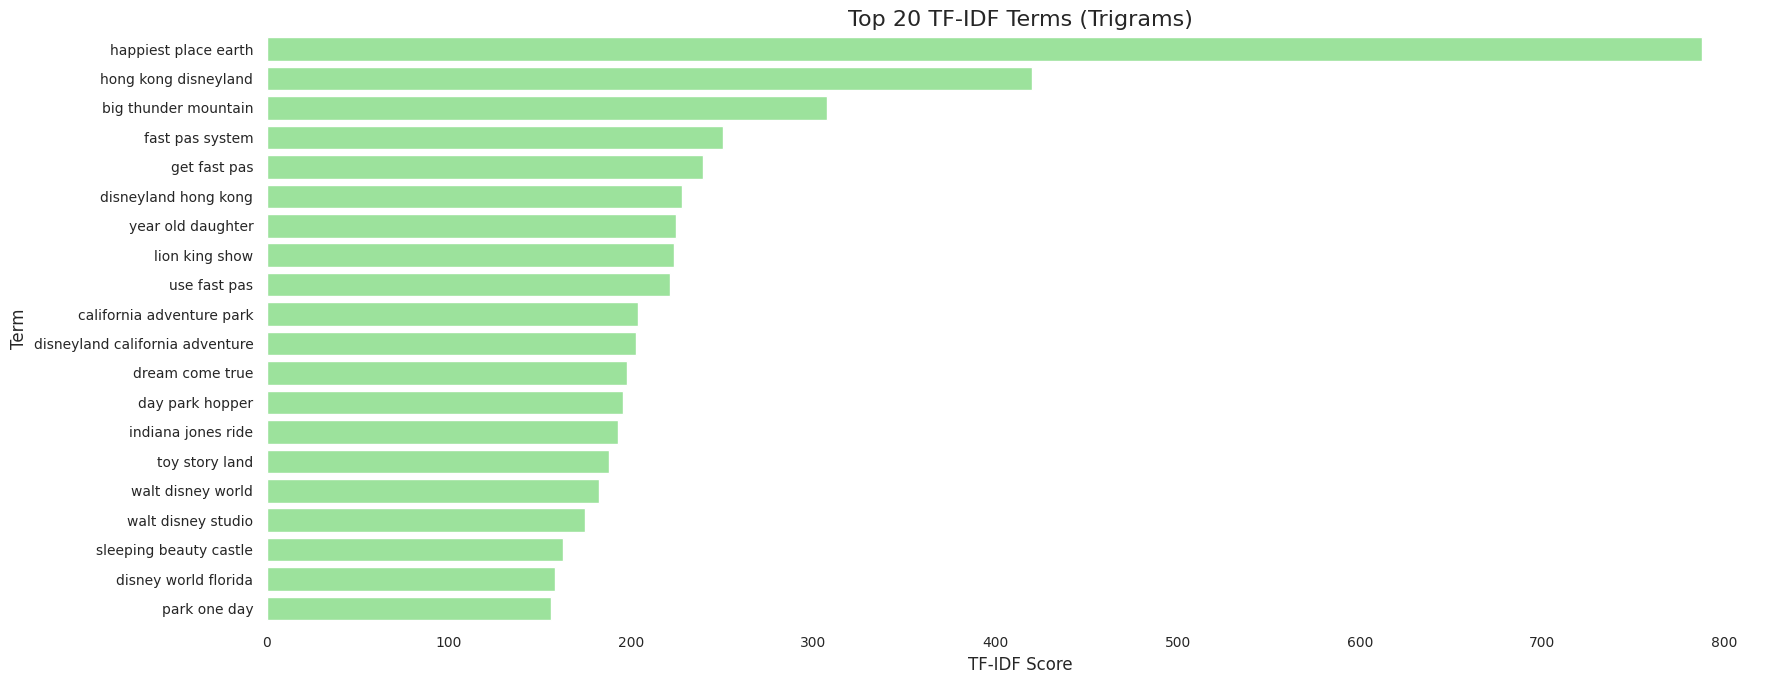

In [27]:
# Ensure Clean_Text column is ready
disney_df['Clean_Text'] = disney_df['Tokens'].apply(lambda tokens: ' '.join(tokens))

# Define n-gram settings
ngram_ranges = [(1, 1), (2, 2), (3, 3)]
titles = ['Unigrams', 'Bigrams', 'Trigrams']
bar_colors = ['skyblue', 'lightcoral', 'lightgreen']

# Loop through n-grams
for ngram, title, color in zip(ngram_ranges, titles, bar_colors):
    vectorizer = TfidfVectorizer(ngram_range=ngram, max_features=1000)
    tfidf_matrix = vectorizer.fit_transform(disney_df['Clean_Text'])

    tfidf_scores = tfidf_matrix.sum(axis=0).A1
    terms = vectorizer.get_feature_names_out()

    top_indices = tfidf_scores.argsort()[::-1][:20]
    top_terms = [(terms[i], tfidf_scores[i]) for i in top_indices]
    words, scores = zip(*top_terms)

    # Plot
    plt.figure(figsize=(18, 7))
    sns.barplot(x=scores, y=words, color=color)

    plt.title(f'Top 20 TF-IDF Terms ({title})', fontsize=16)
    plt.xlabel('TF-IDF Score', fontsize=12)
    plt.ylabel('Term', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Remove grid and all spines
    plt.grid(False)
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    plt.show()

    # Force extra blank space between plots
    print("\n" * 2)


### 7.5 LDA Topic Modelling

In [28]:
# Create combined stopwords
custom_stopwords = set(['disneyland', 'california', 'paris', 'disney', 'hong', 'kong'])
combined_stopwords = ENGLISH_STOP_WORDS.union(stopwords.words('english')).union(custom_stopwords)

# Sentiment labeling and filtering
disney_df['Sentiment_Label'] = disney_df['Sentiment_Score'].apply(
    lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral')
)
disney_df = disney_df[disney_df['Sentiment_Label'] != 'Neutral']

positive_reviews = disney_df[disney_df['Sentiment_Label'] == 'Positive']
negative_reviews = disney_df[disney_df['Sentiment_Label'] == 'Negative']

# Define lda_topics function to create vectorizer, fit_transform, lda, and return feature names
def lda_topics(text_series, n_topics=4):
    vectorizer = CountVectorizer(
        stop_words=list(combined_stopwords),
        ngram_range=(2, 2),  # bigrams only
        max_df=0.8,
        min_df=5
    )
    dtm = vectorizer.fit_transform(text_series)
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=26)
    lda.fit(dtm)
    feature_names = vectorizer.get_feature_names_out()
    return lda, dtm, feature_names

lda_pos, dtm_pos, feat_names_pos = lda_topics(positive_reviews['Clean_Text'], n_topics=4)
lda_neg, dtm_neg, feat_names_neg = lda_topics(negative_reviews['Clean_Text'], n_topics=4)

# Function to get dominant topic per document
def get_dominant_topic(lda_model, dtm):
    topic_distributions = lda_model.transform(dtm)
    dominant_topics = topic_distributions.argmax(axis=1)
    return dominant_topics

positive_reviews = positive_reviews.copy()
negative_reviews = negative_reviews.copy()

positive_reviews['Dominant_Topic_Pos'] = get_dominant_topic(lda_pos, dtm_pos)
negative_reviews['Dominant_Topic_Neg'] = get_dominant_topic(lda_neg, dtm_neg)

# Function to display top words per topic
def display_top_words(lda_model, feature_names, n_top_words=10):
    topics_words = []
    for topic_idx, topic in enumerate(lda_model.components_):
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_indices]
        topics_words.append(top_words)
    return topics_words

positive_top_words = display_top_words(lda_pos, feat_names_pos)
negative_top_words = display_top_words(lda_neg, feat_names_neg)

# Display themes
print("Positive Review Themes:\n")
for i, words in enumerate(positive_top_words):
    print(f"Theme {i+1}: {', '.join(words)}")

print("\nNegative Review Themes:\n")
for i, words in enumerate(negative_top_words):
    print(f"Theme {i+1}: {', '.join(words)}")

Positive Review Themes:

Theme 1: year old, fast pas, space mountain, thunder mountain, peter pan, indiana jones, fast pass, great time, big thunder, small world
Theme 2: place earth, happiest place, cast member, space mountain, haunted mansion, small world, indiana jones, pirate caribbean, star war, day park
Theme 3: fast pas, wait time, fast pass, long line, day park, great time, time year, park hopper, year old, cast member
Theme 4: theme park, lion king, main street, toy story, make sure, small world, long queue, mickey mouse, parade firework, year old

Negative Review Themes:

Theme 1: ride closed, star war, indiana jones, space mountain, haunted mansion, thunder mountain, ride broke, theme park, small world, fast pas
Theme 2: cast member, fast pas, space mountain, year old, place earth, happiest place, wait time, day park, fast pass, main street
Theme 3: fast pas, year old, theme park, customer service, long queue, day park, waiting time, queue ride, small world, technical proble

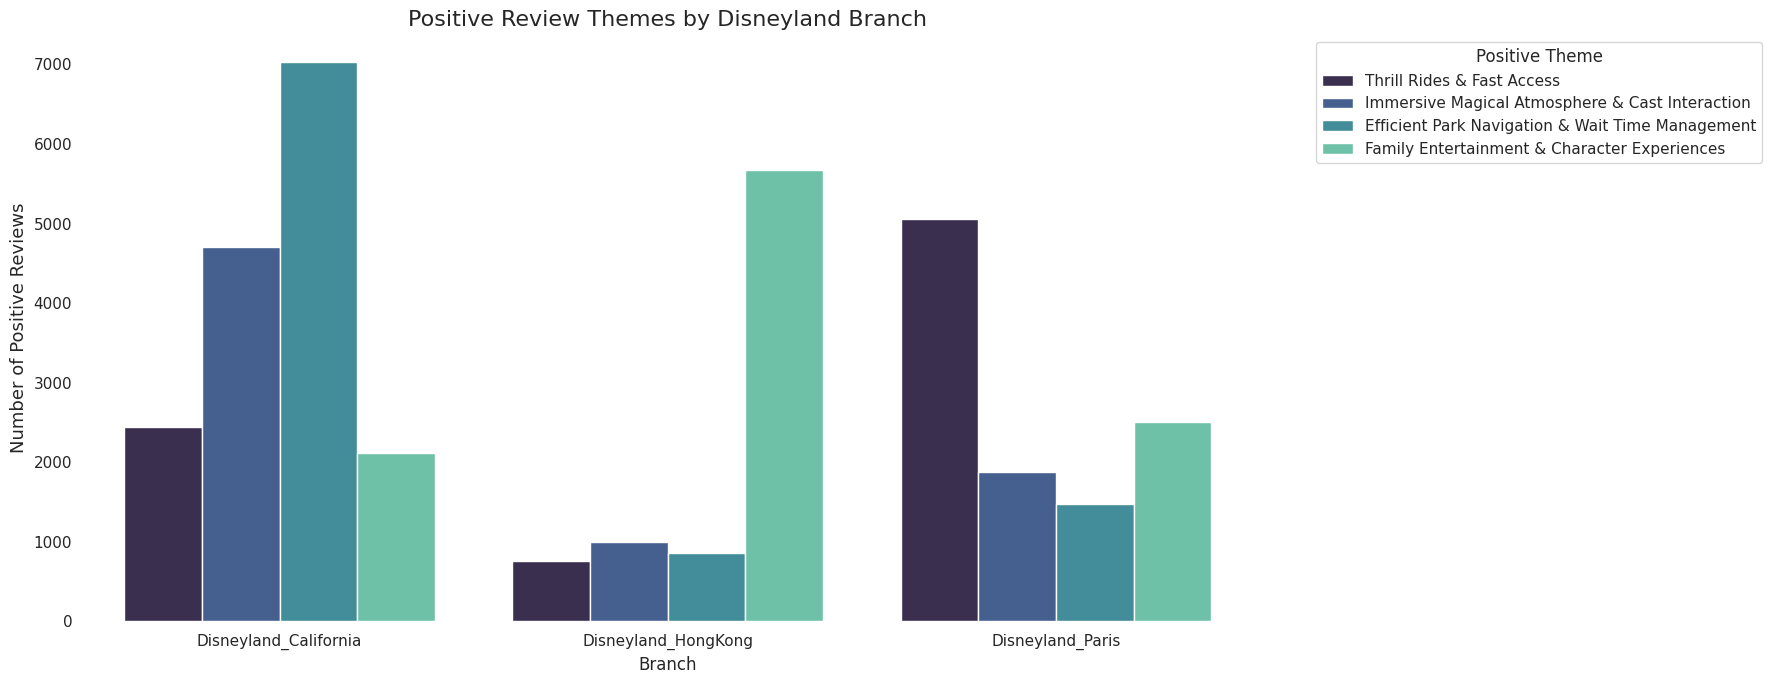

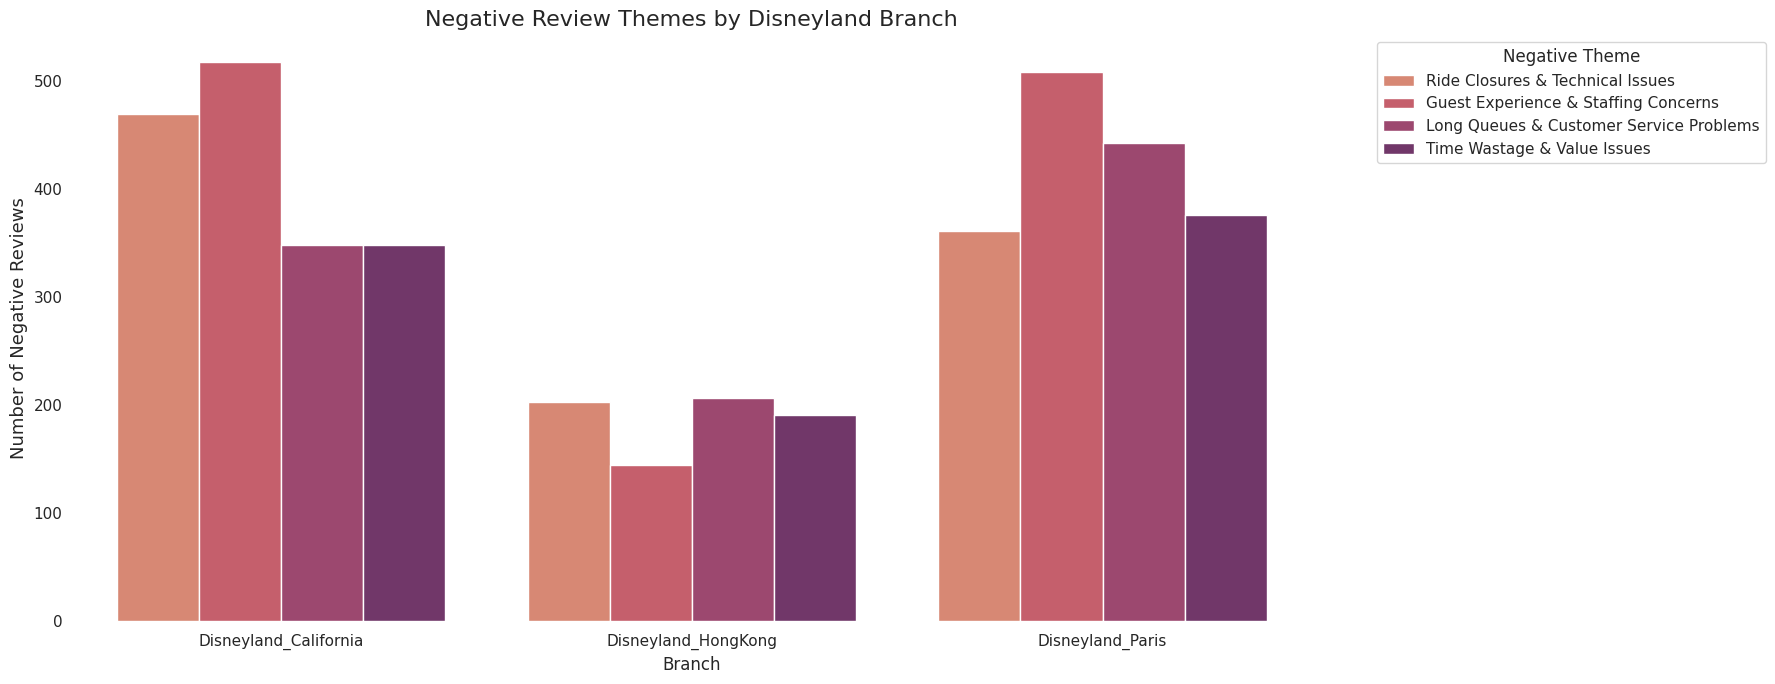

In [29]:
# Labels for themes
positive_labels = [
    "Thrill Rides & Fast Access",
    "Immersive Magical Atmosphere & Cast Interaction",
    "Efficient Park Navigation & Wait Time Management",
    "Family Entertainment & Character Experiences"
]

negative_labels = [
    "Ride Closures & Technical Issues",
    "Guest Experience & Staffing Concerns",
    "Long Queues & Customer Service Problems",
    "Time Wastage & Value Issues"
]

# Aggregate counts by branch and dominant topic
pos_summary = positive_reviews.groupby(['Branch', 'Dominant_Topic_Pos']).size().reset_index(name='Count')
pos_summary['Theme'] = pos_summary['Dominant_Topic_Pos'].apply(lambda x: positive_labels[int(x)])
pos_summary['Sentiment'] = 'Positive'

neg_summary = negative_reviews.groupby(['Branch', 'Dominant_Topic_Neg']).size().reset_index(name='Count')
neg_summary['Theme'] = neg_summary['Dominant_Topic_Neg'].apply(lambda x: negative_labels[int(x)])
neg_summary['Sentiment'] = 'Negative'

# Combine positive and negative summaries for visualization
summary_df = pd.concat([
    pos_summary.rename(columns={'Dominant_Topic_Pos': 'Topic'}),
    neg_summary.rename(columns={'Dominant_Topic_Neg': 'Topic'})
], ignore_index=True)

# Separate summary for positive and negative
positive_summary_df = summary_df[summary_df['Sentiment'] == 'Positive']
negative_summary_df = summary_df[summary_df['Sentiment'] == 'Negative']

# Plot for Positive Themes
plt.figure(figsize=(18, 7))
sns.barplot(data=positive_summary_df, x='Branch', y='Count', hue='Theme', palette='mako')
plt.title('Positive Review Themes by Disneyland Branch',  fontsize=16)
plt.ylabel('Number of Positive Reviews', fontsize = 13)
plt.xticks()
plt.grid(False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.legend(title='Positive Theme', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Force extra blank space between plots
print("\n" * 2)

# Plot for Negative Themes
plt.figure(figsize=(18, 7))
sns.barplot(data=negative_summary_df, x='Branch', y='Count', hue='Theme', palette='flare')
plt.title('Negative Review Themes by Disneyland Branch',  fontsize=16)
plt.ylabel('Number of Negative Reviews', fontsize = 13)
plt.xticks()
plt.grid(False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.legend(title='Negative Theme', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### **Topic Modelling Interpretation**

* **Positive Reviews**

The chart on positive review themes reveals that each Disneyland branch is praised for distinct strengths. Disneyland California receives the most positive feedback overall, particularly for Efficient Park Navigation & Wait Time Management, suggesting that guests value smooth logistics, effective Fast Pass systems, and manageable wait times. Disneyland Hong Kong stands out almost exclusively for Family Entertainment & Character Experiences, indicating a strong focus on child-friendly attractions, character interactions, and shows. Meanwhile, Disneyland Paris is most positively associated with Thrill Rides & Fast Access, showing that guests are especially drawn to its iconic, high-adrenaline attractions like Space Mountain and Indiana Jones. These differences highlight how each park delivers its magic in unique ways, catering to varied visitor expectations and preferences.

* **Negative Reviews**

The chart on negative review themes provides critical insight into recurring visitor frustrations across the Disneyland branches. Disneyland California sees the highest volume of negative feedback overall, with Guest Experience & Staffing Concerns and Ride Closures & Technical Issues being the most common complaints, highlighting operational inconsistencies and dissatisfaction with cast member interactions despite its otherwise positive reputation. Disneyland Paris follows a similar pattern, with high counts in Guest Experience, Long Queues, and Time Wastage, suggesting that service delays and perceived value are significant issues. In contrast, Disneyland Hong Kong receives the fewest negative reviews, though concerns are still noted, particularly around Customer Service Problems and Ride Closures. These findings emphasize that while magical experiences are widespread, recurring logistical and service-related issues, especially in California and Paris, can detract from overall guest satisfaction.

### 7.6 positive and negative review themes over time

In [30]:
#Create a Time Period Column
# Convert Year and Month to a datetime object (for sorting and plotting)
positive_reviews['Review_Date'] = pd.to_datetime(positive_reviews[['Year', 'Month']].assign(DAY=1))
negative_reviews['Review_Date'] = pd.to_datetime(negative_reviews[['Year', 'Month']].assign(DAY=1))

In [31]:
# POSITIVE
pos_time = (
    positive_reviews
    .groupby(['Review_Date', 'Branch', 'Dominant_Topic_Pos'])
    .size()
    .reset_index(name='Count')
)
pos_time['Theme'] = pos_time['Dominant_Topic_Pos'].apply(lambda x: positive_labels[int(x)])
pos_time['Sentiment'] = 'Positive'

# NEGATIVE
neg_time = (
    negative_reviews
    .groupby(['Review_Date', 'Branch', 'Dominant_Topic_Neg'])
    .size()
    .reset_index(name='Count')
)
neg_time['Theme'] = neg_time['Dominant_Topic_Neg'].apply(lambda x: negative_labels[int(x)])
neg_time['Sentiment'] = 'Negative'

# Rename for consistency
pos_time = pos_time.rename(columns={'Dominant_Topic_Pos': 'Topic'})
neg_time = neg_time.rename(columns={'Dominant_Topic_Neg': 'Topic'})


In [32]:
# Combine both datasets
theme_time_df = pd.concat([pos_time, neg_time], ignore_index=True)

# Sort before rolling
theme_time_df = theme_time_df.sort_values(by=['Branch', 'Theme', 'Review_Date'])

# Apply rolling mean (3-month window) per Branch and Theme
theme_time_df['Smoothed_Count'] = (
    theme_time_df
    .groupby(['Branch', 'Theme'])['Count']
    .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
)


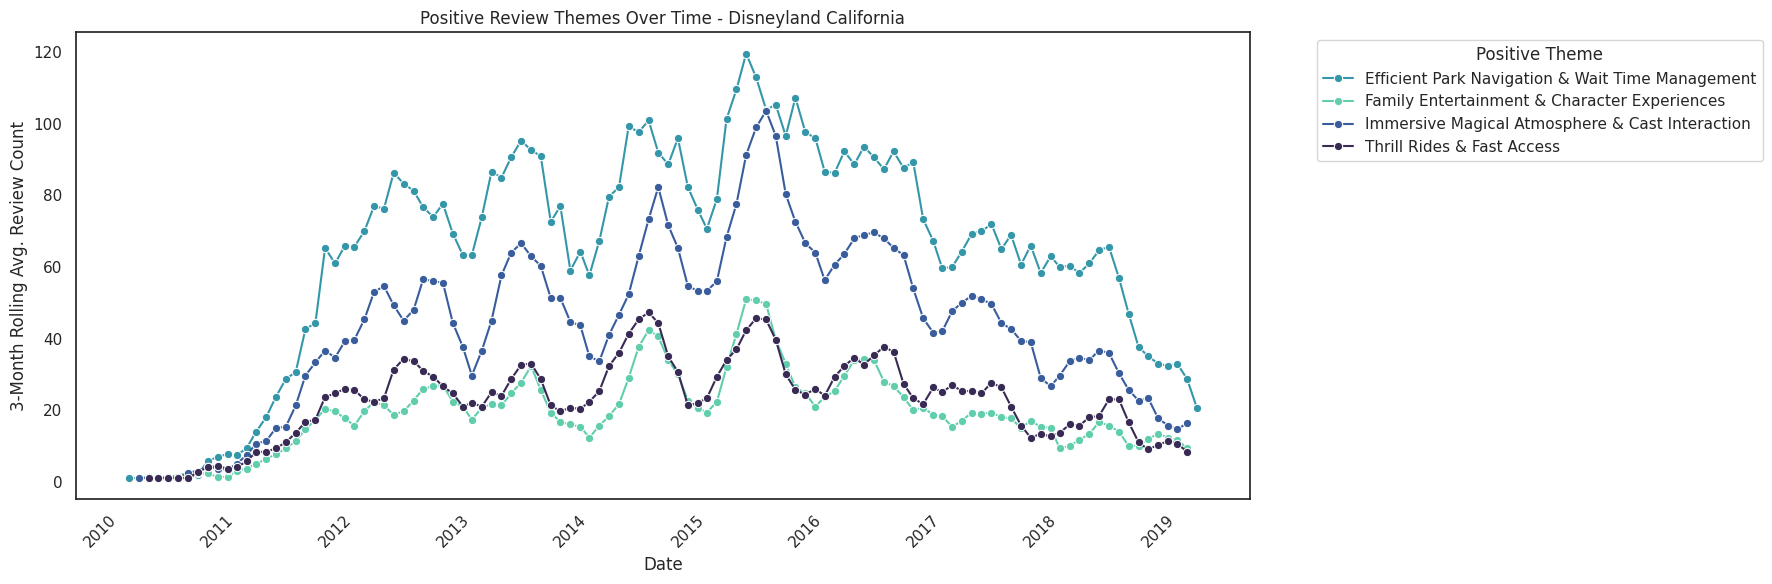

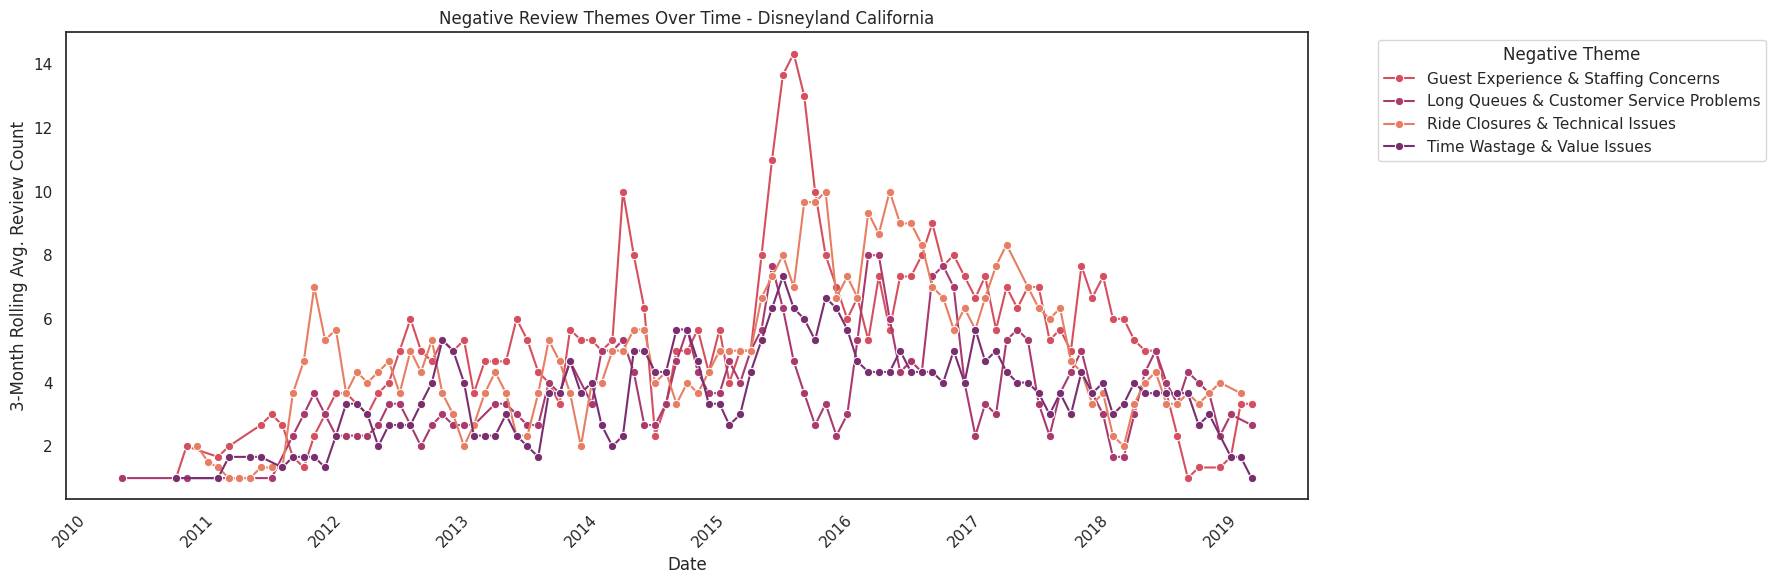

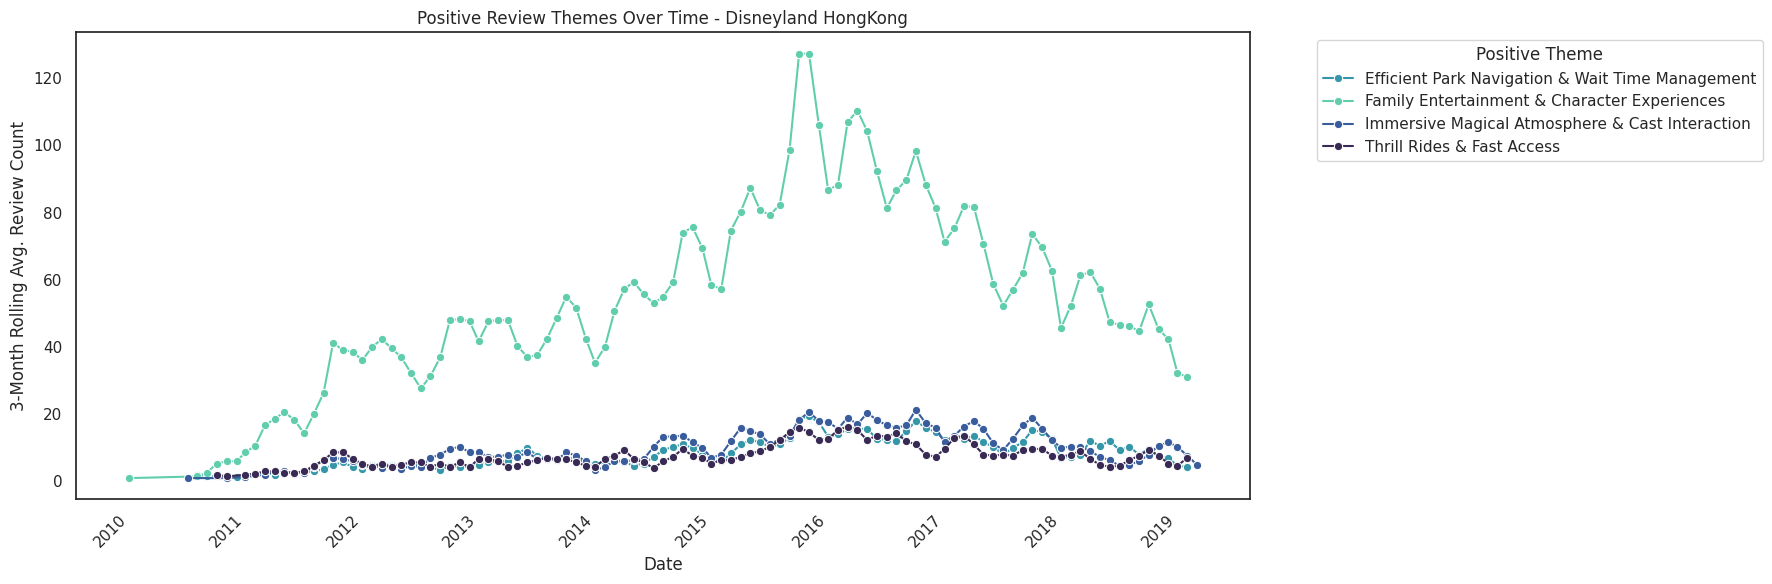

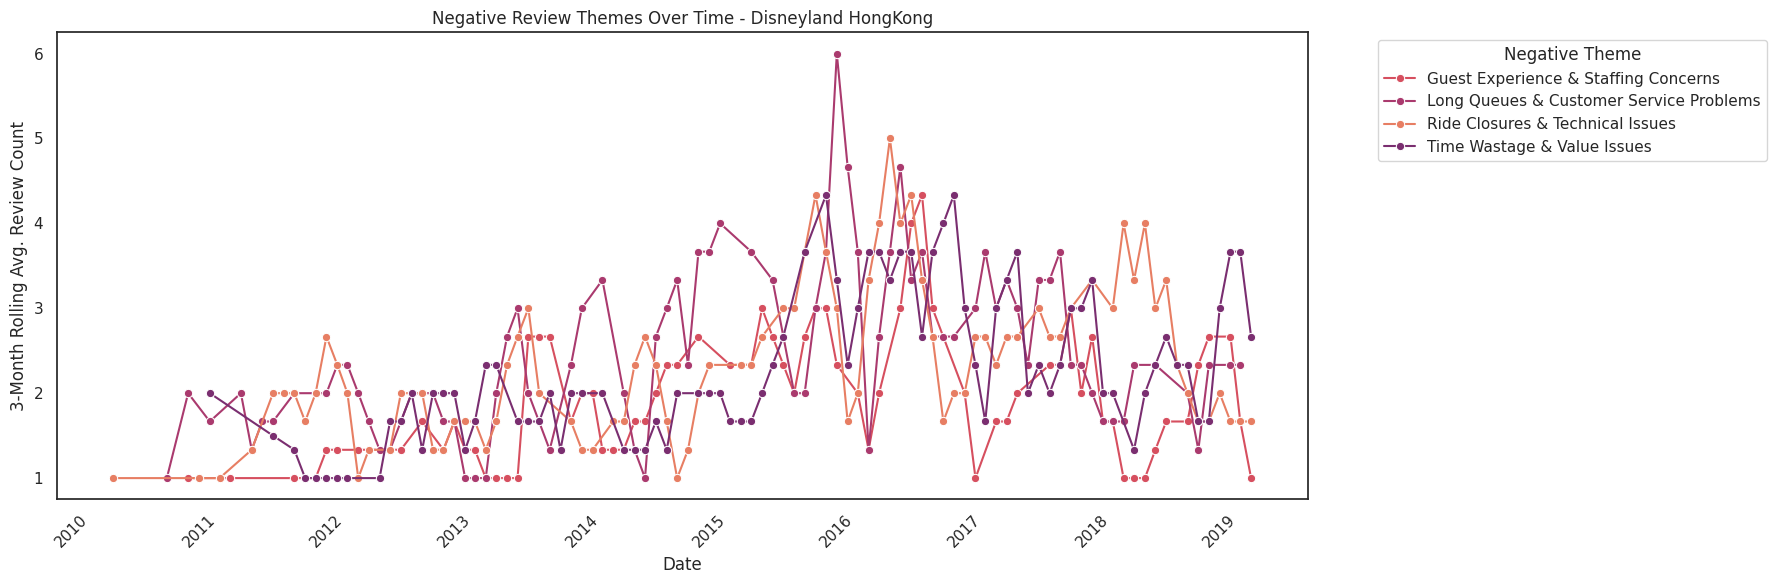

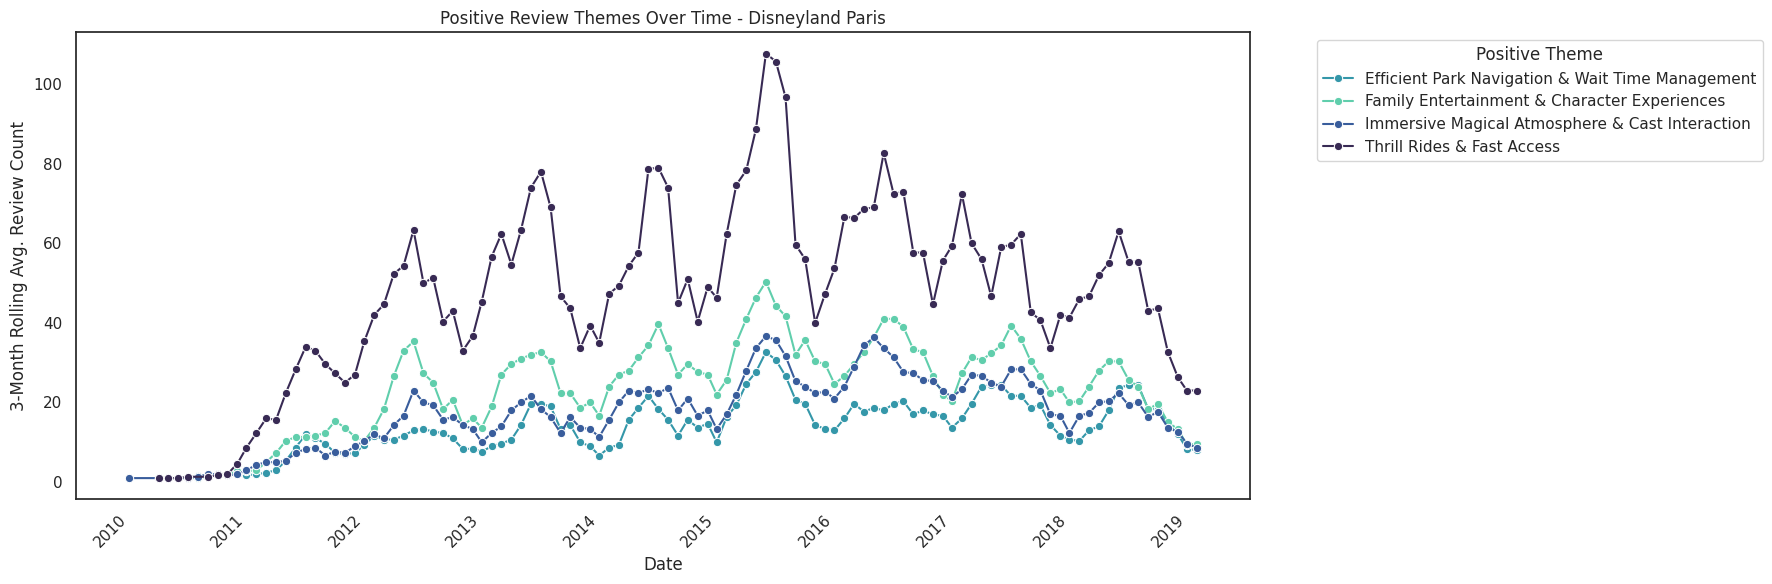

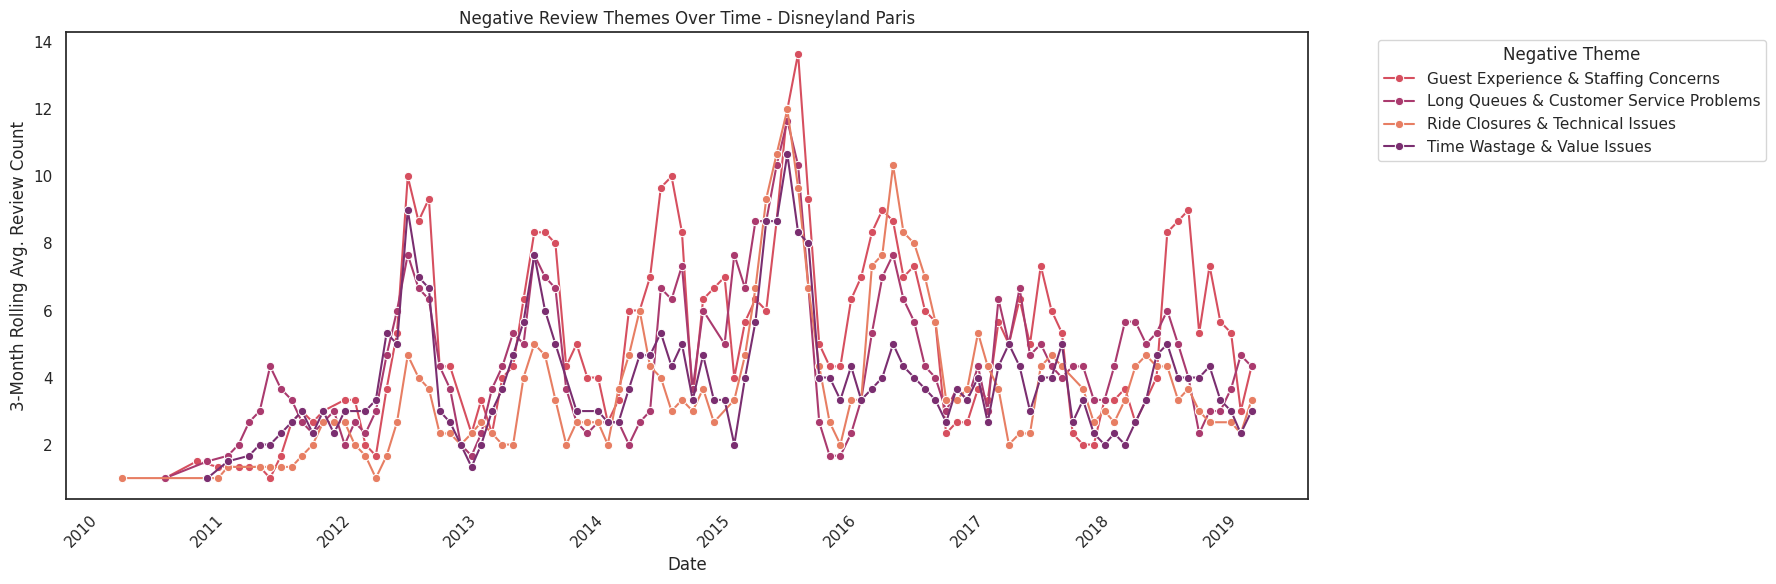

In [33]:
# Generate consistent color maps
positive_palette = dict(zip(positive_labels, sns.color_palette("mako", len(positive_labels))))
negative_palette = dict(zip(negative_labels, sns.color_palette("flare", len(negative_labels))))

# Prep columns
theme_time_df['Branch_Nice'] = theme_time_df['Branch'].str.replace("_", " ")
theme_time_df['Year'] = theme_time_df['Review_Date'].dt.year

# Loop through branches and sentiments
for branch in theme_time_df['Branch'].unique():
    branch_data = theme_time_df[
        (theme_time_df['Branch'] == branch) &
        (theme_time_df['Smoothed_Count'].notna())
    ]
    if branch_data.empty:
        continue

    branch_name = branch.replace("_", " ")

    for sentiment in ['Positive', 'Negative']:
        sentiment_data = branch_data[branch_data['Sentiment'] == sentiment]
        if sentiment_data.empty:
            continue

        # Choose consistent color map
        palette = positive_palette if sentiment == 'Positive' else negative_palette

        # Plot
        plt.figure(figsize=(18, 6))
        sns.lineplot(
            data=sentiment_data,
            x='Review_Date', y='Smoothed_Count',
            hue='Theme', marker='o', palette=palette
        )
        plt.title(f'{sentiment} Review Themes Over Time - {branch_name}')
        plt.ylabel('3-Month Rolling Avg. Review Count')
        plt.xlabel('Date')
        plt.xticks(rotation=45)
        plt.legend(title=f'{sentiment} Theme', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()


### **Reviews over time**

* **Disneyland California**
    - **Positive**: This time series chart reveals how positive review themes for Disneyland California evolved from 2010 to 2019. The most frequently praised theme throughout the years is Efficient Park Navigation & Wait Time Management, peaking around 2015–2016, indicating strong visitor appreciation for logistical improvements during that period. Immersive Magical Atmosphere & Cast Interaction consistently ranks as the second most prominent theme, underscoring the enduring value of Disney's storytelling and staff engagement. Family Entertainment & Character Experiences and Thrill Rides & Fast Access maintain relatively steady but lower volumes, suggesting they were consistently appreciated but not as central to the most memorable experiences. The overall downward trend in all themes after 2016 may reflect either shifting visitor expectations, changes in park operations, or broader industry dynamics that affected review behavior.
    - **Negative**: This chart illustrates how negative review themes for Disneyland California evolved from 2010 to 2019. Guest Experience & Staffing Concerns emerged as the most persistent issue, peaking sharply around 2015–2016, a period when dissatisfaction with cast interactions or service levels likely intensified. Long Queues & Customer Service Problems also remained a steady concern throughout the decade, pointing to ongoing challenges with crowd management and guest support. Ride Closures & Technical Issues and Time Wastage & Value Issues followed similar fluctuating patterns, with moderate spikes but generally lower frequencies. While there’s a slight downward trend in negative themes after 2016, their consistent presence over time suggests that despite improvements, operational and value-related frustrations continued to impact the guest experience.
* **Disneyland Hong Kond**
    - **Positive**: This chart shows the evolution of positive review themes for Disneyland Hong Kong from 2010 to 2019. Family Entertainment & Character Experiences dominated the positive sentiment throughout the period, peaking around 2016, likely due to the introduction of new family-focused attractions or entertainment offerings. In contrast, the other themes, Efficient Park Navigation & Wait Time Management, Immersive Magical Atmosphere & Cast Interaction, and Thrill Rides & Fast Access, remained consistently lower and relatively stable, suggesting they played a more minor role in shaping guest satisfaction. Overall, family-friendly experiences were the primary driver of positive reviews, highlighting the park’s success in appealing to families with children.
    - **Negative**: This chart tracks the negative review themes for Disneyland Hong Kong between 2010 and 2019. Overall, negative sentiments remained relatively low and stable across all categories, indicating a generally positive guest experience. The most persistent concerns were Time Wastage & Value Issues and Ride Closures & Technical Issues, both of which showed slight upticks around 2015–2016, possibly due to operational changes or maintenance periods. Guest Experience & Staffing Concerns and Long Queues & Customer Service Problems appeared sporadically and at low volumes, suggesting that while these issues did arise, they were not consistently widespread or severe throughout the observed period.
* **Disneyland Paris**
    - **Positive**: In Disneyland Paris, Thrill Rides & Fast Access consistently dominated positive review themes from 2010 to 2019, peaking around 2015–2016, indicating a strong guest preference for excitement and efficient ride experiences. The other themes, Family Entertainment & Character Experiences, Immersive Magical Atmosphere & Cast Interaction, and Efficient Park Navigation & Wait Time Management followed similar trends at lower but steady levels, with modest peaks during the same period. This suggests that while guests appreciated various aspects of the park, high-adrenaline attractions were the standout driver of positive sentiment.
    - **Negative**: In Disneyland Paris, negative reviews were largely driven by Guest Experience & Staffing Concerns and Time Wastage & Value Issues, both of which showed repeated spikes between 2012 and 2016, with noticeable peaks around 2015–2016. Ride Closures & Technical Issues and Long Queues & Customer Service Problems also contributed to dissatisfaction, though generally at slightly lower levels. The fluctuating but persistent presence of all four themes suggests recurring operational and service-related challenges that may have affected overall guest satisfaction during this period.


### 8. Dashboard

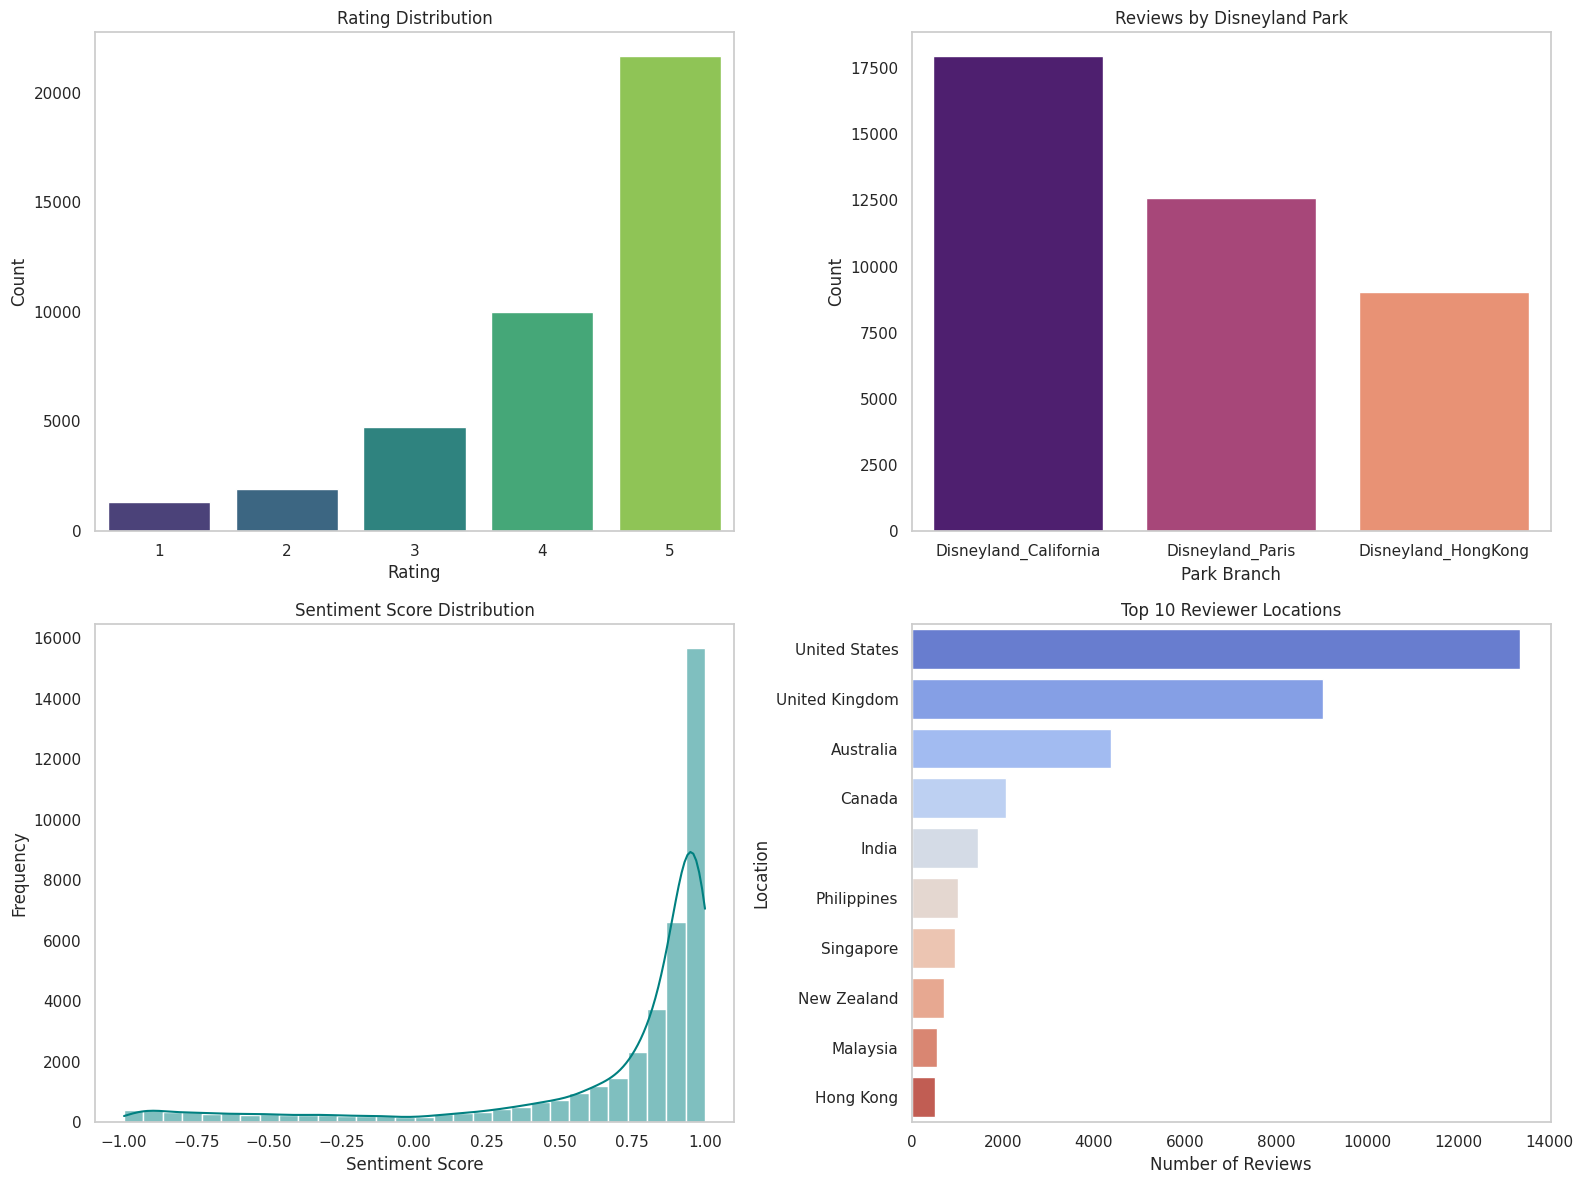

In [37]:
# Set theme
sns.set(style='whitegrid')
plt.figure(figsize=(16, 12))

# Subplot 1: Rating Distribution
plt.subplot(2, 2, 1)
sns.countplot(x='Rating', data=disney_df, palette='viridis')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(False)

# Subplot 2: Reviews by Park
plt.subplot(2, 2, 2)
sns.countplot(x='Branch', data=disney_df, palette='magma', order=disney_df['Branch'].value_counts().index)
plt.title('Reviews by Disneyland Park')
plt.xlabel('Park Branch')
plt.ylabel('Count')
plt.grid(False)

# Subplot 3: Sentiment Score (VADER or your own score)
plt.subplot(2, 2, 3)
sns.histplot(disney_df['Sentiment_Score'], bins=30, kde=True, color='teal')
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(False)

# Subplot 4: Top 10 Reviewer Locations
plt.subplot(2, 2, 4)
top_locs = disney_df['Reviewer_Location'].value_counts().head(10)
sns.barplot(y=top_locs.index, x=top_locs.values, palette='coolwarm')
plt.title('Top 10 Reviewer Locations')
plt.xlabel('Number of Reviews')
plt.ylabel('Location')
plt.grid(False)

plt.tight_layout()
plt.show()

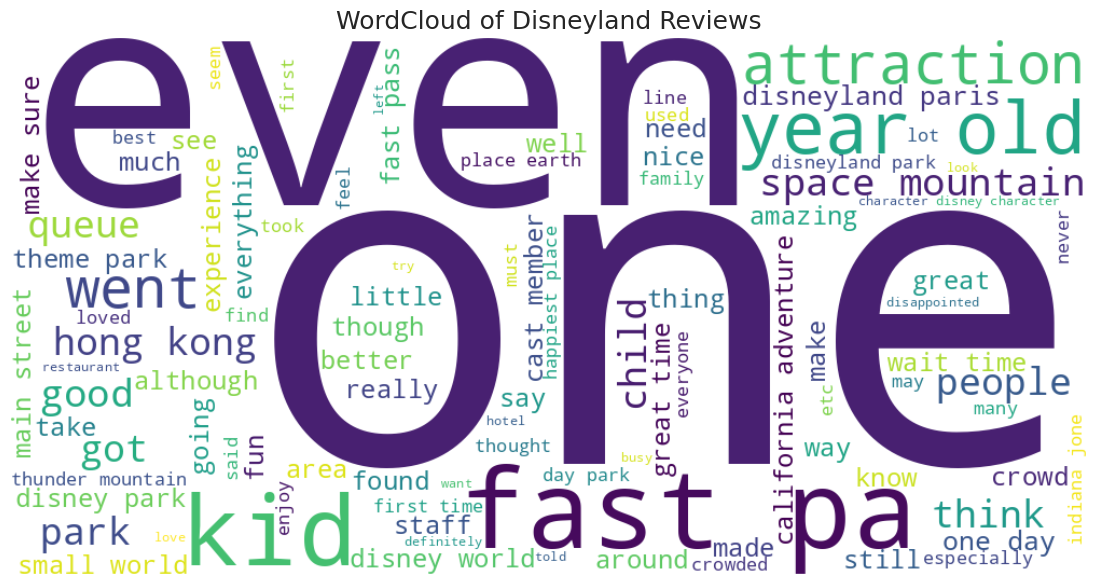

In [38]:
# Join all cleaned text into one big string
text = ' '.join(disney_df['Clean_Text'].dropna().astype(str))

# Generate WordCloud
wordcloud = WordCloud(
    width=1000, height=500,
    background_color='white',
    colormap='viridis',
    max_words=100,
    random_state=42
).generate(text)

# Plot it
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Disneyland Reviews', fontsize=18)
plt.show()
